In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from convnet import DiscriminatorConvNet, GeneratorConvNet
from resnet import DiscriminatorResNet, GeneratorResNet
from utils import *


# Hyperparameters

Taken exactly from the paper.

In [3]:
num_gpu = 1
lr = 1e-4
beta1 = 0
beta2 = 0.9
num_epochs = 5000

dataroot="../data"
batch_size= 64
workers = 4
image_size= 48

real_label = 1
fake_label = -1

# Look for available GPU(s)
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

# Sphere-GAN CONVNET Training

In [14]:
manual_seed = 333
random.seed(manual_seed)

torch.manual_seed(manual_seed)
genConv = GeneratorConvNet().to(device)

torch.manual_seed(manual_seed)
disConv = DiscriminatorConvNet().to(device)

torch.manual_seed(manual_seed)
genConv.apply(weights_init)
torch.manual_seed(manual_seed)
disConv.apply(weights_init)


DiscriminatorConvNet(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (ln1_1): LayerNorm(torch.Size([64, 48, 48]), eps=1e-05, elementwise_affine=True)
  (lrelu1_1): LeakyReLU(negative_slope=0.2, inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (ln1_2): LayerNorm(torch.Size([64, 24, 24]), eps=1e-05, elementwise_affine=True)
  (lrelu1_2): LeakyReLU(negative_slope=0.2, inplace)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (ln2_1): LayerNorm(torch.Size([128, 24, 24]), eps=1e-05, elementwise_affine=True)
  (lrelu2_1): LeakyReLU(negative_slope=0.2, inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (ln2_2): LayerNorm(torch.Size([128, 12, 12]), eps=1e-05, elementwise_affine=True)
  (lrelu2_2): LeakyReLU(negative_slope=0.2, inplace)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

In [15]:
optimizerG = optim.Adam(genConv.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(disConv.parameters(), lr=lr, betas=(beta1, beta2))

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 128, device=device)
dataloader = get_stl10_dataloader(dataroot, batch_size, workers, image_size)
criterion = nn.BCELoss()

img_list = []
G_losses = []
D_losses = []
iters = 0
moments = 5

Files already downloaded and verified


In [16]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update Discriminator
        ###########################
        disConv.zero_grad()
        label = torch.full((batch_size, 1), real_label, device=device)
        
        # Forward pass real batch through D
        output = disConv(data[0].to(device))
        
        # Calculate loss on all-real batch
        error_disc_real = total_moment_distance(output, label, moments, device) # criterion(output, label) #
        
        # Calculate gradients for D in backward pass
        error_disc_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, 128, device=device)
        
        # Generate fake image batch with G
        fake = genConv(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = disConv(fake.detach())
        
        # Calculate D's loss on the all-fake batch
        error_disc_fake = total_moment_distance(output, label, moments, device) # criterion(output, label) #
        
        # Calculate the gradients for this batch
        error_disc_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        error_disc = error_disc_real + error_disc_fake
        #error_disc.backward()
        
        # Update D
        optimizerD.step()

        ############################
        # (2) Update Generator
        ###########################
        genConv.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disConv(fake)
        
        # Calculate G's loss based on this output
        error_gen = total_moment_distance(output, label, moments, device) # criterion(output, label)
        
        # Calculate gradients for G
        error_gen.backward()
        
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     error_disc.item(), error_gen.item()))

        # Save Losses for plotting later
        G_losses.append(error_gen.item())
        D_losses.append(error_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = genConv(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            plt.clf()
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list[-1],(1,2,0)))
            plt.savefig("../figures/fake_iter_{}.svg".format(iters))
            plt.clf()


        iters += 1

[0/5000][0/78]	Loss_D: 0.0003	Loss_G: 0.0081
[0/5000][50/78]	Loss_D: -0.0156	Loss_G: 0.0258
[1/5000][0/78]	Loss_D: -0.0073	Loss_G: 0.0093
[1/5000][50/78]	Loss_D: -0.0093	Loss_G: 0.0112
[2/5000][0/78]	Loss_D: -0.0100	Loss_G: 0.0118
[2/5000][50/78]	Loss_D: -0.0186	Loss_G: 0.0237
[3/5000][0/78]	Loss_D: -0.1263	Loss_G: 0.0138
[3/5000][50/78]	Loss_D: -0.0132	Loss_G: 0.0151
[4/5000][0/78]	Loss_D: -0.0625	Loss_G: 0.0218
[4/5000][50/78]	Loss_D: -0.0187	Loss_G: 0.0221
[5/5000][0/78]	Loss_D: -0.0117	Loss_G: 0.0130
[5/5000][50/78]	Loss_D: -0.0906	Loss_G: 0.0358
[6/5000][0/78]	Loss_D: -0.0306	Loss_G: 0.0393
[6/5000][50/78]	Loss_D: -0.0923	Loss_G: 0.0232
[7/5000][0/78]	Loss_D: -0.0235	Loss_G: 0.0274
[7/5000][50/78]	Loss_D: -0.0179	Loss_G: 0.0195
[8/5000][0/78]	Loss_D: -0.0239	Loss_G: 0.0259
[8/5000][50/78]	Loss_D: -0.0225	Loss_G: 0.0244
[9/5000][0/78]	Loss_D: -0.0387	Loss_G: 0.0501
[9/5000][50/78]	Loss_D: -0.0284	Loss_G: 0.0329
[10/5000][0/78]	Loss_D: -0.1668	Loss_G: 0.0295
[10/5000][50/78]	Loss_D:

[86/5000][50/78]	Loss_D: -0.0046	Loss_G: 0.0424
[87/5000][0/78]	Loss_D: -0.0041	Loss_G: 0.0306
[87/5000][50/78]	Loss_D: -0.0050	Loss_G: 0.0409
[88/5000][0/78]	Loss_D: -0.0016	Loss_G: 0.0224
[88/5000][50/78]	Loss_D: -0.0078	Loss_G: 0.0350
[89/5000][0/78]	Loss_D: -0.0028	Loss_G: 0.0718
[89/5000][50/78]	Loss_D: -0.0089	Loss_G: 0.0508
[90/5000][0/78]	Loss_D: 0.0445	Loss_G: 0.0427
[90/5000][50/78]	Loss_D: -0.0114	Loss_G: 0.0550
[91/5000][0/78]	Loss_D: 0.0012	Loss_G: 0.0034
[91/5000][50/78]	Loss_D: -0.0000	Loss_G: 0.0044
[92/5000][0/78]	Loss_D: -0.0003	Loss_G: 0.0140
[92/5000][50/78]	Loss_D: -0.0009	Loss_G: 0.0148
[93/5000][0/78]	Loss_D: 0.0023	Loss_G: 0.0228
[93/5000][50/78]	Loss_D: -0.0060	Loss_G: 0.0279
[94/5000][0/78]	Loss_D: -0.0002	Loss_G: 0.0291
[94/5000][50/78]	Loss_D: 0.0017	Loss_G: 0.0520
[95/5000][0/78]	Loss_D: 0.0001	Loss_G: 0.0268
[95/5000][50/78]	Loss_D: 0.0002	Loss_G: 0.0998
[96/5000][0/78]	Loss_D: -0.0267	Loss_G: 0.1115
[96/5000][50/78]	Loss_D: -0.0022	Loss_G: 0.2233
[97/5000

[171/5000][50/78]	Loss_D: -20.0564	Loss_G: 128.3969
[172/5000][0/78]	Loss_D: 0.7164	Loss_G: 44.1647
[172/5000][50/78]	Loss_D: -9.3402	Loss_G: 94.0554
[173/5000][0/78]	Loss_D: -32.6305	Loss_G: 84.2277
[173/5000][50/78]	Loss_D: -4.9984	Loss_G: 78.1820
[174/5000][0/78]	Loss_D: -4.0998	Loss_G: 13.6125
[174/5000][50/78]	Loss_D: -33.1116	Loss_G: 76.8809
[175/5000][0/78]	Loss_D: -21.0683	Loss_G: 137.2101
[175/5000][50/78]	Loss_D: -38.5358	Loss_G: 162.9782
[176/5000][0/78]	Loss_D: -29.7645	Loss_G: 34.3453
[176/5000][50/78]	Loss_D: -32.6205	Loss_G: 101.9407
[177/5000][0/78]	Loss_D: -35.3137	Loss_G: 104.2544
[177/5000][50/78]	Loss_D: -79.9785	Loss_G: 60.2311
[178/5000][0/78]	Loss_D: -20.4538	Loss_G: 130.5215
[178/5000][50/78]	Loss_D: -2.4465	Loss_G: 37.1313
[179/5000][0/78]	Loss_D: -21.3257	Loss_G: 159.5821
[179/5000][50/78]	Loss_D: -60.8056	Loss_G: 133.8730
[180/5000][0/78]	Loss_D: -11.8766	Loss_G: 139.8437
[180/5000][50/78]	Loss_D: -60.4378	Loss_G: 15.8337
[181/5000][0/78]	Loss_D: -4.5828	Loss

[251/5000][50/78]	Loss_D: -30.3771	Loss_G: 230.9993
[252/5000][0/78]	Loss_D: -89.0358	Loss_G: 56.3446
[252/5000][50/78]	Loss_D: -141.9911	Loss_G: 128.6841
[253/5000][0/78]	Loss_D: -128.0955	Loss_G: 205.4632
[253/5000][50/78]	Loss_D: -146.4289	Loss_G: 135.2952
[254/5000][0/78]	Loss_D: -91.7196	Loss_G: 154.7621
[254/5000][50/78]	Loss_D: -67.7407	Loss_G: 269.9140
[255/5000][0/78]	Loss_D: -93.3986	Loss_G: 225.5688
[255/5000][50/78]	Loss_D: -15.8939	Loss_G: 93.4559
[256/5000][0/78]	Loss_D: -32.7207	Loss_G: 243.3087
[256/5000][50/78]	Loss_D: -50.7464	Loss_G: 262.7461
[257/5000][0/78]	Loss_D: -132.2243	Loss_G: 214.3168
[257/5000][50/78]	Loss_D: -103.2358	Loss_G: 229.4071
[258/5000][0/78]	Loss_D: -83.2328	Loss_G: 166.4187
[258/5000][50/78]	Loss_D: -85.5576	Loss_G: 132.1970
[259/5000][0/78]	Loss_D: -70.2772	Loss_G: 227.8514
[259/5000][50/78]	Loss_D: -69.0641	Loss_G: 269.4280
[260/5000][0/78]	Loss_D: -82.1314	Loss_G: 216.6546
[260/5000][50/78]	Loss_D: -78.3211	Loss_G: 265.1086
[261/5000][0/78]	L

[330/5000][50/78]	Loss_D: -159.0652	Loss_G: 249.1470
[331/5000][0/78]	Loss_D: -141.9352	Loss_G: 227.0194
[331/5000][50/78]	Loss_D: -106.5768	Loss_G: 307.0863
[332/5000][0/78]	Loss_D: -127.0690	Loss_G: 173.5962
[332/5000][50/78]	Loss_D: -132.1562	Loss_G: 321.3203
[333/5000][0/78]	Loss_D: -125.1230	Loss_G: 230.2665
[333/5000][50/78]	Loss_D: -118.2743	Loss_G: 309.3686
[334/5000][0/78]	Loss_D: -206.8136	Loss_G: 259.4484
[334/5000][50/78]	Loss_D: -85.7100	Loss_G: 264.7361
[335/5000][0/78]	Loss_D: -125.1120	Loss_G: 280.1989
[335/5000][50/78]	Loss_D: -168.6823	Loss_G: 266.2444
[336/5000][0/78]	Loss_D: -136.1378	Loss_G: 303.8229
[336/5000][50/78]	Loss_D: -105.5213	Loss_G: 295.4396
[337/5000][0/78]	Loss_D: -161.5757	Loss_G: 261.8776
[337/5000][50/78]	Loss_D: -195.4668	Loss_G: 227.7130
[338/5000][0/78]	Loss_D: -121.6353	Loss_G: 270.0359
[338/5000][50/78]	Loss_D: -137.3315	Loss_G: 215.4826
[339/5000][0/78]	Loss_D: -176.8921	Loss_G: 275.0353
[339/5000][50/78]	Loss_D: -114.9671	Loss_G: 131.5503
[34

[409/5000][0/78]	Loss_D: -167.0479	Loss_G: 337.6452
[409/5000][50/78]	Loss_D: -152.9327	Loss_G: 311.5668
[410/5000][0/78]	Loss_D: -159.0626	Loss_G: 267.2182
[410/5000][50/78]	Loss_D: -159.0578	Loss_G: 250.8561
[411/5000][0/78]	Loss_D: -193.6623	Loss_G: 251.3338
[411/5000][50/78]	Loss_D: -191.9106	Loss_G: 294.1970
[412/5000][0/78]	Loss_D: -213.4015	Loss_G: 229.4016
[412/5000][50/78]	Loss_D: -245.4851	Loss_G: 280.2134
[413/5000][0/78]	Loss_D: -245.3604	Loss_G: 278.2838
[413/5000][50/78]	Loss_D: -198.6809	Loss_G: 229.3930
[414/5000][0/78]	Loss_D: -150.0205	Loss_G: 337.9456
[414/5000][50/78]	Loss_D: -179.3048	Loss_G: 273.5578
[415/5000][0/78]	Loss_D: -164.3231	Loss_G: 304.5234
[415/5000][50/78]	Loss_D: -175.5875	Loss_G: 227.2822
[416/5000][0/78]	Loss_D: -198.2908	Loss_G: 245.0079
[416/5000][50/78]	Loss_D: -208.8121	Loss_G: 305.4738
[417/5000][0/78]	Loss_D: -118.1215	Loss_G: 295.5477
[417/5000][50/78]	Loss_D: -182.7016	Loss_G: 337.8312
[418/5000][0/78]	Loss_D: -92.9685	Loss_G: 319.4457
[418

[487/5000][50/78]	Loss_D: -193.6390	Loss_G: 327.7367
[488/5000][0/78]	Loss_D: -213.6508	Loss_G: 285.5029
[488/5000][50/78]	Loss_D: -188.2606	Loss_G: 339.5307
[489/5000][0/78]	Loss_D: -270.0787	Loss_G: 322.5573
[489/5000][50/78]	Loss_D: -237.0539	Loss_G: 258.9085
[490/5000][0/78]	Loss_D: -236.1362	Loss_G: 338.7169
[490/5000][50/78]	Loss_D: -144.3452	Loss_G: 296.6994
[491/5000][0/78]	Loss_D: -177.1493	Loss_G: 315.3286
[491/5000][50/78]	Loss_D: -118.2306	Loss_G: 264.0717
[492/5000][0/78]	Loss_D: -199.8155	Loss_G: 320.1370
[492/5000][50/78]	Loss_D: -175.3120	Loss_G: 290.0451
[493/5000][0/78]	Loss_D: -153.0209	Loss_G: 320.7614
[493/5000][50/78]	Loss_D: -184.8403	Loss_G: 264.6203
[494/5000][0/78]	Loss_D: -273.7890	Loss_G: 266.8403
[494/5000][50/78]	Loss_D: -188.5115	Loss_G: 353.4334
[495/5000][0/78]	Loss_D: -192.4818	Loss_G: 253.0570
[495/5000][50/78]	Loss_D: -216.4891	Loss_G: 282.6035
[496/5000][0/78]	Loss_D: -165.1888	Loss_G: 325.5968
[496/5000][50/78]	Loss_D: -198.4410	Loss_G: 235.5692
[4

[566/5000][0/78]	Loss_D: -267.2490	Loss_G: 346.5109
[566/5000][50/78]	Loss_D: -212.8859	Loss_G: 271.7893
[567/5000][0/78]	Loss_D: -204.6779	Loss_G: 300.1539
[567/5000][50/78]	Loss_D: -266.0291	Loss_G: 333.8744
[568/5000][0/78]	Loss_D: -237.5962	Loss_G: 299.9573
[568/5000][50/78]	Loss_D: -269.3730	Loss_G: 316.5330
[569/5000][0/78]	Loss_D: -248.1832	Loss_G: 302.6133
[569/5000][50/78]	Loss_D: -215.7587	Loss_G: 264.4201
[570/5000][0/78]	Loss_D: -223.3839	Loss_G: 344.5054
[570/5000][50/78]	Loss_D: -264.2135	Loss_G: 312.9758
[571/5000][0/78]	Loss_D: -275.4796	Loss_G: 318.6509
[571/5000][50/78]	Loss_D: -246.5450	Loss_G: 335.7441
[572/5000][0/78]	Loss_D: -250.1044	Loss_G: 327.4498
[572/5000][50/78]	Loss_D: -187.3341	Loss_G: 278.1916
[573/5000][0/78]	Loss_D: -205.6946	Loss_G: 355.9208
[573/5000][50/78]	Loss_D: -256.1487	Loss_G: 321.1093
[574/5000][0/78]	Loss_D: -233.0826	Loss_G: 326.8619
[574/5000][50/78]	Loss_D: -201.7065	Loss_G: 335.6188
[575/5000][0/78]	Loss_D: -260.9927	Loss_G: 348.0319
[57

[644/5000][50/78]	Loss_D: -258.5961	Loss_G: 312.6328
[645/5000][0/78]	Loss_D: -188.2201	Loss_G: 371.5540
[645/5000][50/78]	Loss_D: -183.6669	Loss_G: 371.5753
[646/5000][0/78]	Loss_D: -299.9368	Loss_G: 361.2498
[646/5000][50/78]	Loss_D: -297.9289	Loss_G: 364.0490
[647/5000][0/78]	Loss_D: -257.2281	Loss_G: 324.8777
[647/5000][50/78]	Loss_D: -221.5998	Loss_G: 329.0578
[648/5000][0/78]	Loss_D: -199.0038	Loss_G: 376.4125
[648/5000][50/78]	Loss_D: -252.0919	Loss_G: 292.7535
[649/5000][0/78]	Loss_D: -174.1643	Loss_G: 295.4172
[649/5000][50/78]	Loss_D: -239.4343	Loss_G: 346.0960
[650/5000][0/78]	Loss_D: -223.9684	Loss_G: 311.9609
[650/5000][50/78]	Loss_D: -279.3134	Loss_G: 372.1982
[651/5000][0/78]	Loss_D: -253.0443	Loss_G: 357.4737
[651/5000][50/78]	Loss_D: -292.9079	Loss_G: 362.1476
[652/5000][0/78]	Loss_D: -261.2664	Loss_G: 317.5838
[652/5000][50/78]	Loss_D: -277.2850	Loss_G: 342.2057
[653/5000][0/78]	Loss_D: -217.7616	Loss_G: 391.0778
[653/5000][50/78]	Loss_D: -254.0243	Loss_G: 350.5214
[6

[723/5000][0/78]	Loss_D: -264.5417	Loss_G: 327.0689
[723/5000][50/78]	Loss_D: -273.3990	Loss_G: 342.1099
[724/5000][0/78]	Loss_D: -267.1746	Loss_G: 330.8297
[724/5000][50/78]	Loss_D: -292.3390	Loss_G: 305.9787
[725/5000][0/78]	Loss_D: -250.8345	Loss_G: 330.9678
[725/5000][50/78]	Loss_D: -242.0542	Loss_G: 352.3228
[726/5000][0/78]	Loss_D: -313.2807	Loss_G: 367.9889
[726/5000][50/78]	Loss_D: -278.6720	Loss_G: 294.9637
[727/5000][0/78]	Loss_D: -247.5710	Loss_G: 361.5252
[727/5000][50/78]	Loss_D: -269.1034	Loss_G: 354.6491
[728/5000][0/78]	Loss_D: -246.8127	Loss_G: 341.4869
[728/5000][50/78]	Loss_D: -282.3687	Loss_G: 356.3411
[729/5000][0/78]	Loss_D: -216.3774	Loss_G: 279.3581
[729/5000][50/78]	Loss_D: -252.5818	Loss_G: 357.4356
[730/5000][0/78]	Loss_D: -216.5458	Loss_G: 186.8335
[730/5000][50/78]	Loss_D: -256.7221	Loss_G: 350.8872
[731/5000][0/78]	Loss_D: -138.0212	Loss_G: 291.6799
[731/5000][50/78]	Loss_D: -236.7128	Loss_G: 283.5089
[732/5000][0/78]	Loss_D: -193.2160	Loss_G: 330.0516
[73

[801/5000][50/78]	Loss_D: -302.1364	Loss_G: 343.5829
[802/5000][0/78]	Loss_D: -271.9322	Loss_G: 401.6624
[802/5000][50/78]	Loss_D: -285.8206	Loss_G: 355.7100
[803/5000][0/78]	Loss_D: -288.4306	Loss_G: 392.4768
[803/5000][50/78]	Loss_D: -315.5934	Loss_G: 366.8835
[804/5000][0/78]	Loss_D: -275.2520	Loss_G: 385.4892
[804/5000][50/78]	Loss_D: -322.6559	Loss_G: 375.1038
[805/5000][0/78]	Loss_D: -306.1396	Loss_G: 333.7842
[805/5000][50/78]	Loss_D: -281.9110	Loss_G: 322.6821
[806/5000][0/78]	Loss_D: -268.5454	Loss_G: 277.6689
[806/5000][50/78]	Loss_D: -314.5010	Loss_G: 380.1001
[807/5000][0/78]	Loss_D: -292.3675	Loss_G: 363.6077
[807/5000][50/78]	Loss_D: -295.0503	Loss_G: 374.4163
[808/5000][0/78]	Loss_D: -318.3755	Loss_G: 360.2612
[808/5000][50/78]	Loss_D: -273.9833	Loss_G: 316.8231
[809/5000][0/78]	Loss_D: -254.3865	Loss_G: 315.8830
[809/5000][50/78]	Loss_D: -266.1106	Loss_G: 359.3322
[810/5000][0/78]	Loss_D: -231.3913	Loss_G: 355.4959
[810/5000][50/78]	Loss_D: -269.7653	Loss_G: 318.4282
[8

[880/5000][0/78]	Loss_D: -296.1226	Loss_G: 323.8064
[880/5000][50/78]	Loss_D: -320.6431	Loss_G: 385.5846
[881/5000][0/78]	Loss_D: -295.4534	Loss_G: 354.8604
[881/5000][50/78]	Loss_D: -302.5303	Loss_G: 335.3783
[882/5000][0/78]	Loss_D: -345.1794	Loss_G: 393.5231
[882/5000][50/78]	Loss_D: -314.7747	Loss_G: 324.6859
[883/5000][0/78]	Loss_D: -349.4257	Loss_G: 399.9467
[883/5000][50/78]	Loss_D: -310.3883	Loss_G: 360.5861
[884/5000][0/78]	Loss_D: -255.3302	Loss_G: 331.4512
[884/5000][50/78]	Loss_D: -304.5916	Loss_G: 354.9799
[885/5000][0/78]	Loss_D: -275.2415	Loss_G: 307.2755
[885/5000][50/78]	Loss_D: -294.6270	Loss_G: 335.8618
[886/5000][0/78]	Loss_D: -296.0187	Loss_G: 387.6215
[886/5000][50/78]	Loss_D: -261.8388	Loss_G: 389.1701
[887/5000][0/78]	Loss_D: -259.3229	Loss_G: 382.4913
[887/5000][50/78]	Loss_D: -250.5708	Loss_G: 352.3603
[888/5000][0/78]	Loss_D: -285.4710	Loss_G: 267.1656
[888/5000][50/78]	Loss_D: -300.0089	Loss_G: 325.1279
[889/5000][0/78]	Loss_D: -292.4529	Loss_G: 310.9304
[88

[958/5000][50/78]	Loss_D: -306.0363	Loss_G: 410.6197
[959/5000][0/78]	Loss_D: -326.7018	Loss_G: 306.1385
[959/5000][50/78]	Loss_D: -333.3539	Loss_G: 365.6469
[960/5000][0/78]	Loss_D: -333.6208	Loss_G: 357.6976
[960/5000][50/78]	Loss_D: -344.9195	Loss_G: 386.7642
[961/5000][0/78]	Loss_D: -261.7329	Loss_G: 376.1474
[961/5000][50/78]	Loss_D: -282.2674	Loss_G: 388.9078
[962/5000][0/78]	Loss_D: -345.5837	Loss_G: 374.7359
[962/5000][50/78]	Loss_D: -347.2249	Loss_G: 339.4637
[963/5000][0/78]	Loss_D: -282.6262	Loss_G: 290.2031
[963/5000][50/78]	Loss_D: -322.2902	Loss_G: 400.1098
[964/5000][0/78]	Loss_D: -305.0466	Loss_G: 378.1177
[964/5000][50/78]	Loss_D: -325.4316	Loss_G: 265.8544
[965/5000][0/78]	Loss_D: -348.9591	Loss_G: 346.3214
[965/5000][50/78]	Loss_D: -307.2616	Loss_G: 362.6870
[966/5000][0/78]	Loss_D: -294.8219	Loss_G: 405.7169
[966/5000][50/78]	Loss_D: -310.9407	Loss_G: 342.3595
[967/5000][0/78]	Loss_D: -348.8167	Loss_G: 365.9974
[967/5000][50/78]	Loss_D: -355.8572	Loss_G: 334.5115
[9

[1036/5000][0/78]	Loss_D: -349.0125	Loss_G: 361.0860
[1036/5000][50/78]	Loss_D: -352.1819	Loss_G: 375.0511
[1037/5000][0/78]	Loss_D: -308.4023	Loss_G: 402.0612
[1037/5000][50/78]	Loss_D: -284.5940	Loss_G: 401.3141
[1038/5000][0/78]	Loss_D: -306.8131	Loss_G: 397.4885
[1038/5000][50/78]	Loss_D: -322.4008	Loss_G: 378.1410
[1039/5000][0/78]	Loss_D: -303.0534	Loss_G: 337.5142
[1039/5000][50/78]	Loss_D: -320.5752	Loss_G: 395.7196
[1040/5000][0/78]	Loss_D: -328.2203	Loss_G: 385.5157
[1040/5000][50/78]	Loss_D: -334.8469	Loss_G: 348.2832
[1041/5000][0/78]	Loss_D: -321.8724	Loss_G: 394.7279
[1041/5000][50/78]	Loss_D: -357.8511	Loss_G: 402.3311
[1042/5000][0/78]	Loss_D: -347.0780	Loss_G: 401.7749
[1042/5000][50/78]	Loss_D: -368.8303	Loss_G: 375.5813
[1043/5000][0/78]	Loss_D: -345.0876	Loss_G: 391.1716
[1043/5000][50/78]	Loss_D: -332.3568	Loss_G: 377.7716
[1044/5000][0/78]	Loss_D: -325.3198	Loss_G: 349.5798
[1044/5000][50/78]	Loss_D: -354.7519	Loss_G: 377.5734
[1045/5000][0/78]	Loss_D: -336.0790	L

[1113/5000][0/78]	Loss_D: -334.9814	Loss_G: 376.2232
[1113/5000][50/78]	Loss_D: -352.5016	Loss_G: 399.5020
[1114/5000][0/78]	Loss_D: -342.5370	Loss_G: 355.2733
[1114/5000][50/78]	Loss_D: -343.1236	Loss_G: 374.0536
[1115/5000][0/78]	Loss_D: -274.6172	Loss_G: 280.8629
[1115/5000][50/78]	Loss_D: -355.8333	Loss_G: 384.3432
[1116/5000][0/78]	Loss_D: -328.5298	Loss_G: 388.8242
[1116/5000][50/78]	Loss_D: -361.1484	Loss_G: 384.0790
[1117/5000][0/78]	Loss_D: -327.1574	Loss_G: 338.8315
[1117/5000][50/78]	Loss_D: -361.9324	Loss_G: 378.2610
[1118/5000][0/78]	Loss_D: -333.4014	Loss_G: 419.1029
[1118/5000][50/78]	Loss_D: -334.4694	Loss_G: 392.1946
[1119/5000][0/78]	Loss_D: -368.8748	Loss_G: 413.5574
[1119/5000][50/78]	Loss_D: -328.6681	Loss_G: 357.4196
[1120/5000][0/78]	Loss_D: -353.8611	Loss_G: 345.3920
[1120/5000][50/78]	Loss_D: -360.7256	Loss_G: 347.6025
[1121/5000][0/78]	Loss_D: -356.5982	Loss_G: 395.3860
[1121/5000][50/78]	Loss_D: -354.8549	Loss_G: 383.8221
[1122/5000][0/78]	Loss_D: -338.5887	L

[1190/5000][0/78]	Loss_D: -281.2016	Loss_G: 307.7322
[1190/5000][50/78]	Loss_D: -357.1060	Loss_G: 399.9606
[1191/5000][0/78]	Loss_D: -377.3806	Loss_G: 381.6534
[1191/5000][50/78]	Loss_D: -349.2664	Loss_G: 408.8490
[1192/5000][0/78]	Loss_D: -387.0414	Loss_G: 391.1574
[1192/5000][50/78]	Loss_D: -358.3573	Loss_G: 369.3651
[1193/5000][0/78]	Loss_D: -334.7346	Loss_G: 390.5984
[1193/5000][50/78]	Loss_D: -336.8193	Loss_G: 350.1078
[1194/5000][0/78]	Loss_D: -290.1258	Loss_G: 288.7984
[1194/5000][50/78]	Loss_D: -328.3741	Loss_G: 415.9144
[1195/5000][0/78]	Loss_D: -352.5151	Loss_G: 386.6226
[1195/5000][50/78]	Loss_D: -351.9820	Loss_G: 350.1231
[1196/5000][0/78]	Loss_D: -355.6714	Loss_G: 401.9260
[1196/5000][50/78]	Loss_D: -340.5773	Loss_G: 370.5942
[1197/5000][0/78]	Loss_D: -320.2113	Loss_G: 413.7760
[1197/5000][50/78]	Loss_D: -368.2072	Loss_G: 404.3425
[1198/5000][0/78]	Loss_D: -358.4929	Loss_G: 384.6061
[1198/5000][50/78]	Loss_D: -326.6056	Loss_G: 339.1528
[1199/5000][0/78]	Loss_D: -361.5362	L

[1267/5000][0/78]	Loss_D: -361.6580	Loss_G: 360.6570
[1267/5000][50/78]	Loss_D: -365.6848	Loss_G: 408.7473
[1268/5000][0/78]	Loss_D: -353.3221	Loss_G: 333.7700
[1268/5000][50/78]	Loss_D: -388.9185	Loss_G: 395.5289
[1269/5000][0/78]	Loss_D: -357.9539	Loss_G: 385.2185
[1269/5000][50/78]	Loss_D: -379.4738	Loss_G: 383.7252
[1270/5000][0/78]	Loss_D: -382.2482	Loss_G: 397.0366
[1270/5000][50/78]	Loss_D: -363.3857	Loss_G: 418.2413
[1271/5000][0/78]	Loss_D: -363.3215	Loss_G: 412.4182
[1271/5000][50/78]	Loss_D: -382.6262	Loss_G: 395.0469
[1272/5000][0/78]	Loss_D: -379.8207	Loss_G: 394.8565
[1272/5000][50/78]	Loss_D: -342.9653	Loss_G: 372.6190
[1273/5000][0/78]	Loss_D: -341.5860	Loss_G: 391.7342
[1273/5000][50/78]	Loss_D: -375.2001	Loss_G: 381.5731
[1274/5000][0/78]	Loss_D: -354.9633	Loss_G: 365.7025
[1274/5000][50/78]	Loss_D: -367.4193	Loss_G: 384.4355
[1275/5000][0/78]	Loss_D: -393.6310	Loss_G: 384.7195
[1275/5000][50/78]	Loss_D: -380.7269	Loss_G: 411.8121
[1276/5000][0/78]	Loss_D: -338.3582	L

[1344/5000][0/78]	Loss_D: -360.2128	Loss_G: 334.9315
[1344/5000][50/78]	Loss_D: -377.3123	Loss_G: 417.7039
[1345/5000][0/78]	Loss_D: -360.2135	Loss_G: 391.2130
[1345/5000][50/78]	Loss_D: -387.6109	Loss_G: 380.2452
[1346/5000][0/78]	Loss_D: -361.0624	Loss_G: 405.4603
[1346/5000][50/78]	Loss_D: -339.1702	Loss_G: 362.9515
[1347/5000][0/78]	Loss_D: -376.8445	Loss_G: 401.8137
[1347/5000][50/78]	Loss_D: -361.0343	Loss_G: 403.0846
[1348/5000][0/78]	Loss_D: -310.7618	Loss_G: 356.8776
[1348/5000][50/78]	Loss_D: -377.8881	Loss_G: 407.2079
[1349/5000][0/78]	Loss_D: -269.4303	Loss_G: 379.0973
[1349/5000][50/78]	Loss_D: -397.9341	Loss_G: 389.6760
[1350/5000][0/78]	Loss_D: -354.4776	Loss_G: 408.0605
[1350/5000][50/78]	Loss_D: -375.6578	Loss_G: 415.1272
[1351/5000][0/78]	Loss_D: -341.3735	Loss_G: 407.7814
[1351/5000][50/78]	Loss_D: -355.9333	Loss_G: 370.5096
[1352/5000][0/78]	Loss_D: -394.4005	Loss_G: 393.4755
[1352/5000][50/78]	Loss_D: -372.0901	Loss_G: 367.0473
[1353/5000][0/78]	Loss_D: -380.0689	L

[1421/5000][0/78]	Loss_D: -339.2240	Loss_G: 385.1416
[1421/5000][50/78]	Loss_D: -399.2958	Loss_G: 413.1844
[1422/5000][0/78]	Loss_D: -409.0127	Loss_G: 416.9362
[1422/5000][50/78]	Loss_D: -375.7152	Loss_G: 387.7677
[1423/5000][0/78]	Loss_D: -374.4792	Loss_G: 421.5985
[1423/5000][50/78]	Loss_D: -374.4962	Loss_G: 398.6035
[1424/5000][0/78]	Loss_D: -372.9134	Loss_G: 250.8428
[1424/5000][50/78]	Loss_D: -384.5027	Loss_G: 398.2589
[1425/5000][0/78]	Loss_D: -382.8184	Loss_G: 412.6880
[1425/5000][50/78]	Loss_D: -357.4509	Loss_G: 382.2815
[1426/5000][0/78]	Loss_D: -390.7334	Loss_G: 397.7402
[1426/5000][50/78]	Loss_D: -385.8571	Loss_G: 401.6668
[1427/5000][0/78]	Loss_D: -378.0251	Loss_G: 386.1596
[1427/5000][50/78]	Loss_D: -377.7198	Loss_G: 410.2449
[1428/5000][0/78]	Loss_D: -373.8183	Loss_G: 391.8179
[1428/5000][50/78]	Loss_D: -368.0833	Loss_G: 392.1051
[1429/5000][0/78]	Loss_D: -374.3378	Loss_G: 382.7399
[1429/5000][50/78]	Loss_D: -398.0291	Loss_G: 389.5392
[1430/5000][0/78]	Loss_D: -385.4667	L

[1498/5000][0/78]	Loss_D: -389.7585	Loss_G: 409.7348
[1498/5000][50/78]	Loss_D: -377.7472	Loss_G: 369.5590
[1499/5000][0/78]	Loss_D: -387.5302	Loss_G: 413.5375
[1499/5000][50/78]	Loss_D: -390.5172	Loss_G: 409.0948
[1500/5000][0/78]	Loss_D: -401.5371	Loss_G: 404.2027
[1500/5000][50/78]	Loss_D: -377.0667	Loss_G: 363.2501
[1501/5000][0/78]	Loss_D: -401.3228	Loss_G: 372.7352
[1501/5000][50/78]	Loss_D: -404.4085	Loss_G: 411.7435
[1502/5000][0/78]	Loss_D: -375.6004	Loss_G: 294.0207
[1502/5000][50/78]	Loss_D: -399.6544	Loss_G: 417.5801
[1503/5000][0/78]	Loss_D: -386.7784	Loss_G: 401.2361
[1503/5000][50/78]	Loss_D: -376.1858	Loss_G: 410.5405
[1504/5000][0/78]	Loss_D: -405.2405	Loss_G: 395.9185
[1504/5000][50/78]	Loss_D: -344.1656	Loss_G: 357.9367
[1505/5000][0/78]	Loss_D: -374.3365	Loss_G: 358.6164
[1505/5000][50/78]	Loss_D: -363.9843	Loss_G: 394.1617
[1506/5000][0/78]	Loss_D: -382.9399	Loss_G: 383.6389
[1506/5000][50/78]	Loss_D: -357.8010	Loss_G: 403.8821
[1507/5000][0/78]	Loss_D: -398.0356	L

[1575/5000][0/78]	Loss_D: -394.1159	Loss_G: 429.6142
[1575/5000][50/78]	Loss_D: -391.6875	Loss_G: 421.0057
[1576/5000][0/78]	Loss_D: -400.6990	Loss_G: 407.3634
[1576/5000][50/78]	Loss_D: -394.9319	Loss_G: 422.6669
[1577/5000][0/78]	Loss_D: -351.6976	Loss_G: 419.3802
[1577/5000][50/78]	Loss_D: -378.1118	Loss_G: 385.1940
[1578/5000][0/78]	Loss_D: -395.4131	Loss_G: 406.7705
[1578/5000][50/78]	Loss_D: -393.6107	Loss_G: 411.9432
[1579/5000][0/78]	Loss_D: -402.7732	Loss_G: 410.6959
[1579/5000][50/78]	Loss_D: -379.0146	Loss_G: 394.3083
[1580/5000][0/78]	Loss_D: -365.3698	Loss_G: 380.3357
[1580/5000][50/78]	Loss_D: -343.0938	Loss_G: 359.1956
[1581/5000][0/78]	Loss_D: -391.8469	Loss_G: 414.0693
[1581/5000][50/78]	Loss_D: -400.4455	Loss_G: 411.7238
[1582/5000][0/78]	Loss_D: -387.7115	Loss_G: 419.6161
[1582/5000][50/78]	Loss_D: -404.1656	Loss_G: 410.4258
[1583/5000][0/78]	Loss_D: -266.3015	Loss_G: 363.1788
[1583/5000][50/78]	Loss_D: -350.7918	Loss_G: 425.0624
[1584/5000][0/78]	Loss_D: -343.7462	L

[1652/5000][0/78]	Loss_D: -390.7837	Loss_G: 406.6558
[1652/5000][50/78]	Loss_D: -381.7238	Loss_G: 389.0266
[1653/5000][0/78]	Loss_D: -400.5778	Loss_G: 412.5339
[1653/5000][50/78]	Loss_D: -381.2378	Loss_G: 409.2641
[1654/5000][0/78]	Loss_D: -368.5265	Loss_G: 361.0986
[1654/5000][50/78]	Loss_D: -409.7814	Loss_G: 406.5697
[1655/5000][0/78]	Loss_D: -397.2483	Loss_G: 415.3791
[1655/5000][50/78]	Loss_D: -398.3689	Loss_G: 414.0567
[1656/5000][0/78]	Loss_D: -409.3822	Loss_G: 410.6087
[1656/5000][50/78]	Loss_D: -389.2364	Loss_G: 419.0899
[1657/5000][0/78]	Loss_D: -402.8521	Loss_G: 408.3472
[1657/5000][50/78]	Loss_D: -397.5183	Loss_G: 402.5600
[1658/5000][0/78]	Loss_D: -393.0682	Loss_G: 414.6790
[1658/5000][50/78]	Loss_D: -383.6057	Loss_G: 371.3773
[1659/5000][0/78]	Loss_D: -384.9408	Loss_G: 422.2778
[1659/5000][50/78]	Loss_D: -408.8576	Loss_G: 417.5397
[1660/5000][0/78]	Loss_D: -391.7438	Loss_G: 411.9340
[1660/5000][50/78]	Loss_D: -387.7860	Loss_G: 420.8253
[1661/5000][0/78]	Loss_D: -392.7256	L

[1729/5000][0/78]	Loss_D: -404.7242	Loss_G: 417.1869
[1729/5000][50/78]	Loss_D: -400.9696	Loss_G: 391.9816
[1730/5000][0/78]	Loss_D: -327.1770	Loss_G: 403.9526
[1730/5000][50/78]	Loss_D: -397.9882	Loss_G: 422.4837
[1731/5000][0/78]	Loss_D: -401.5197	Loss_G: 420.8173
[1731/5000][50/78]	Loss_D: -402.4132	Loss_G: 411.0188
[1732/5000][0/78]	Loss_D: -401.8394	Loss_G: 404.1884
[1732/5000][50/78]	Loss_D: -408.0715	Loss_G: 412.5109
[1733/5000][0/78]	Loss_D: -405.9031	Loss_G: 397.3965
[1733/5000][50/78]	Loss_D: -374.8743	Loss_G: 415.3397
[1734/5000][0/78]	Loss_D: -404.5058	Loss_G: 408.9575
[1734/5000][50/78]	Loss_D: -409.5501	Loss_G: 406.4678
[1735/5000][0/78]	Loss_D: -399.0137	Loss_G: 408.6018
[1735/5000][50/78]	Loss_D: -405.4313	Loss_G: 414.1248
[1736/5000][0/78]	Loss_D: -395.1214	Loss_G: 420.6291
[1736/5000][50/78]	Loss_D: -405.1874	Loss_G: 412.1642
[1737/5000][0/78]	Loss_D: -364.9333	Loss_G: 420.9649
[1737/5000][50/78]	Loss_D: -375.0132	Loss_G: 415.2439
[1738/5000][0/78]	Loss_D: -380.4435	L

[1806/5000][0/78]	Loss_D: -398.8106	Loss_G: 418.3212
[1806/5000][50/78]	Loss_D: -400.2444	Loss_G: 422.1527
[1807/5000][0/78]	Loss_D: -366.1452	Loss_G: 430.3642
[1807/5000][50/78]	Loss_D: -390.6356	Loss_G: 378.9556
[1808/5000][0/78]	Loss_D: -397.8892	Loss_G: 421.5561
[1808/5000][50/78]	Loss_D: -389.9390	Loss_G: 419.0401
[1809/5000][0/78]	Loss_D: -412.4137	Loss_G: 401.8749
[1809/5000][50/78]	Loss_D: -378.0956	Loss_G: 406.8773
[1810/5000][0/78]	Loss_D: -399.9567	Loss_G: 406.0899
[1810/5000][50/78]	Loss_D: -401.4241	Loss_G: 407.3020
[1811/5000][0/78]	Loss_D: -407.8552	Loss_G: 405.4396
[1811/5000][50/78]	Loss_D: -408.8134	Loss_G: 415.9760
[1812/5000][0/78]	Loss_D: -399.2007	Loss_G: 421.0604
[1812/5000][50/78]	Loss_D: -408.8615	Loss_G: 408.9789
[1813/5000][0/78]	Loss_D: -345.9620	Loss_G: 360.0388
[1813/5000][50/78]	Loss_D: -404.1153	Loss_G: 419.0862
[1814/5000][0/78]	Loss_D: -360.4413	Loss_G: 315.1449
[1814/5000][50/78]	Loss_D: -401.0393	Loss_G: 417.9211
[1815/5000][0/78]	Loss_D: -383.0518	L

[1883/5000][0/78]	Loss_D: -383.0614	Loss_G: 416.1943
[1883/5000][50/78]	Loss_D: -297.3322	Loss_G: 391.2080
[1884/5000][0/78]	Loss_D: -384.7134	Loss_G: 405.6069
[1884/5000][50/78]	Loss_D: -341.7190	Loss_G: 373.0523
[1885/5000][0/78]	Loss_D: -414.9409	Loss_G: 421.6894
[1885/5000][50/78]	Loss_D: -391.9358	Loss_G: 413.5396
[1886/5000][0/78]	Loss_D: -412.1106	Loss_G: 419.1925
[1886/5000][50/78]	Loss_D: -384.3842	Loss_G: 373.7732
[1887/5000][0/78]	Loss_D: -411.1696	Loss_G: 417.4214
[1887/5000][50/78]	Loss_D: -385.8167	Loss_G: 422.5511
[1888/5000][0/78]	Loss_D: -401.4599	Loss_G: 377.6514
[1888/5000][50/78]	Loss_D: -399.6772	Loss_G: 397.5156
[1889/5000][0/78]	Loss_D: -396.7891	Loss_G: 419.4107
[1889/5000][50/78]	Loss_D: -379.0289	Loss_G: 368.0874
[1890/5000][0/78]	Loss_D: -397.5742	Loss_G: 377.8801
[1890/5000][50/78]	Loss_D: -317.0874	Loss_G: 290.4754
[1891/5000][0/78]	Loss_D: -344.4000	Loss_G: 398.1780
[1891/5000][50/78]	Loss_D: -405.5252	Loss_G: 417.3597
[1892/5000][0/78]	Loss_D: -380.9348	L

[1960/5000][0/78]	Loss_D: -413.2192	Loss_G: 423.4915
[1960/5000][50/78]	Loss_D: -393.6712	Loss_G: 399.7640
[1961/5000][0/78]	Loss_D: -392.6839	Loss_G: 413.4569
[1961/5000][50/78]	Loss_D: -411.6528	Loss_G: 406.8806
[1962/5000][0/78]	Loss_D: -391.0751	Loss_G: 411.4120
[1962/5000][50/78]	Loss_D: -399.2083	Loss_G: 428.5171
[1963/5000][0/78]	Loss_D: -406.2043	Loss_G: 421.3788
[1963/5000][50/78]	Loss_D: -392.7104	Loss_G: 433.3380
[1964/5000][0/78]	Loss_D: -387.3234	Loss_G: 418.5798
[1964/5000][50/78]	Loss_D: -406.9453	Loss_G: 421.2140
[1965/5000][0/78]	Loss_D: -400.5524	Loss_G: 425.5296
[1965/5000][50/78]	Loss_D: -407.2702	Loss_G: 407.5644
[1966/5000][0/78]	Loss_D: -414.7492	Loss_G: 414.7515
[1966/5000][50/78]	Loss_D: -399.7495	Loss_G: 406.0284
[1967/5000][0/78]	Loss_D: -372.4110	Loss_G: 424.6415
[1967/5000][50/78]	Loss_D: -363.6423	Loss_G: 415.4050
[1968/5000][0/78]	Loss_D: -406.4999	Loss_G: 395.4280
[1968/5000][50/78]	Loss_D: -390.7549	Loss_G: 425.1573
[1969/5000][0/78]	Loss_D: -404.3342	L

[2037/5000][0/78]	Loss_D: -412.9181	Loss_G: 421.6543
[2037/5000][50/78]	Loss_D: -413.6587	Loss_G: 417.9687
[2038/5000][0/78]	Loss_D: -346.7155	Loss_G: 350.2382
[2038/5000][50/78]	Loss_D: -389.4771	Loss_G: 397.1718
[2039/5000][0/78]	Loss_D: -405.2218	Loss_G: 238.0843
[2039/5000][50/78]	Loss_D: -405.1738	Loss_G: 429.8014
[2040/5000][0/78]	Loss_D: -402.0279	Loss_G: 421.3598
[2040/5000][50/78]	Loss_D: -413.4294	Loss_G: 387.8101
[2041/5000][0/78]	Loss_D: -429.6870	Loss_G: 423.6559
[2041/5000][50/78]	Loss_D: -382.9269	Loss_G: 419.1491
[2042/5000][0/78]	Loss_D: -423.0303	Loss_G: 430.7679
[2042/5000][50/78]	Loss_D: -399.9753	Loss_G: 400.0738
[2043/5000][0/78]	Loss_D: -384.8412	Loss_G: 282.7413
[2043/5000][50/78]	Loss_D: -425.3734	Loss_G: 417.5441
[2044/5000][0/78]	Loss_D: -384.2296	Loss_G: 429.6347
[2044/5000][50/78]	Loss_D: -412.5340	Loss_G: 405.1530
[2045/5000][0/78]	Loss_D: -431.8976	Loss_G: 429.3969
[2045/5000][50/78]	Loss_D: -386.1510	Loss_G: 408.8168
[2046/5000][0/78]	Loss_D: -407.3186	L

[2114/5000][0/78]	Loss_D: -406.7669	Loss_G: 392.3855
[2114/5000][50/78]	Loss_D: -406.9714	Loss_G: 414.9404
[2115/5000][0/78]	Loss_D: -397.7483	Loss_G: 354.5866
[2115/5000][50/78]	Loss_D: -404.6888	Loss_G: 422.7363
[2116/5000][0/78]	Loss_D: -420.3710	Loss_G: 425.5519
[2116/5000][50/78]	Loss_D: -405.6909	Loss_G: 421.1201
[2117/5000][0/78]	Loss_D: -409.7017	Loss_G: 422.0211
[2117/5000][50/78]	Loss_D: -411.9558	Loss_G: 423.9465
[2118/5000][0/78]	Loss_D: -415.2608	Loss_G: 422.7718
[2118/5000][50/78]	Loss_D: -406.6808	Loss_G: 416.2662
[2119/5000][0/78]	Loss_D: -410.2030	Loss_G: 419.4883
[2119/5000][50/78]	Loss_D: -410.4658	Loss_G: 425.8450
[2120/5000][0/78]	Loss_D: -409.4823	Loss_G: 414.6982
[2120/5000][50/78]	Loss_D: -405.1899	Loss_G: 417.7651
[2121/5000][0/78]	Loss_D: -411.6098	Loss_G: 408.4602
[2121/5000][50/78]	Loss_D: -391.1792	Loss_G: 389.9354
[2122/5000][0/78]	Loss_D: -415.3399	Loss_G: 419.7096
[2122/5000][50/78]	Loss_D: -409.7939	Loss_G: 424.9030
[2123/5000][0/78]	Loss_D: -413.9392	L

[2191/5000][0/78]	Loss_D: -414.5865	Loss_G: 408.2760
[2191/5000][50/78]	Loss_D: -420.6461	Loss_G: 417.1737
[2192/5000][0/78]	Loss_D: -410.2917	Loss_G: 422.3338
[2192/5000][50/78]	Loss_D: -409.9342	Loss_G: 403.9861
[2193/5000][0/78]	Loss_D: -408.3665	Loss_G: 423.3130
[2193/5000][50/78]	Loss_D: -402.6284	Loss_G: 408.9638
[2194/5000][0/78]	Loss_D: -394.7013	Loss_G: 419.8470
[2194/5000][50/78]	Loss_D: -408.1089	Loss_G: 409.4062
[2195/5000][0/78]	Loss_D: -394.8094	Loss_G: 394.5322
[2195/5000][50/78]	Loss_D: -397.7473	Loss_G: 417.6613
[2196/5000][0/78]	Loss_D: -369.8328	Loss_G: 293.4174
[2196/5000][50/78]	Loss_D: -412.9057	Loss_G: 428.7451
[2197/5000][0/78]	Loss_D: -412.9145	Loss_G: 414.9923
[2197/5000][50/78]	Loss_D: -411.6731	Loss_G: 420.4091
[2198/5000][0/78]	Loss_D: -410.1271	Loss_G: 427.7816
[2198/5000][50/78]	Loss_D: -409.0570	Loss_G: 408.1672
[2199/5000][0/78]	Loss_D: -405.7867	Loss_G: 420.1104
[2199/5000][50/78]	Loss_D: -346.1076	Loss_G: 401.3810
[2200/5000][0/78]	Loss_D: -408.2173	L

[2268/5000][0/78]	Loss_D: -413.3078	Loss_G: 423.3235
[2268/5000][50/78]	Loss_D: -421.9411	Loss_G: 410.5170
[2269/5000][0/78]	Loss_D: -401.2326	Loss_G: 421.0548
[2269/5000][50/78]	Loss_D: -380.0755	Loss_G: 423.8148
[2270/5000][0/78]	Loss_D: -416.3242	Loss_G: 425.9963
[2270/5000][50/78]	Loss_D: -391.2865	Loss_G: 419.7606
[2271/5000][0/78]	Loss_D: -423.8749	Loss_G: 410.1209
[2271/5000][50/78]	Loss_D: -390.3249	Loss_G: 425.5980
[2272/5000][0/78]	Loss_D: -424.1762	Loss_G: 418.3139
[2272/5000][50/78]	Loss_D: -398.9530	Loss_G: 421.8446
[2273/5000][0/78]	Loss_D: -401.0218	Loss_G: 431.0551
[2273/5000][50/78]	Loss_D: -420.5898	Loss_G: 417.1193
[2274/5000][0/78]	Loss_D: -400.0913	Loss_G: 417.3700
[2274/5000][50/78]	Loss_D: -419.5240	Loss_G: 423.0950
[2275/5000][0/78]	Loss_D: -388.2411	Loss_G: 389.1873
[2275/5000][50/78]	Loss_D: -409.5351	Loss_G: 424.8977
[2276/5000][0/78]	Loss_D: -337.9735	Loss_G: 377.9869
[2276/5000][50/78]	Loss_D: -408.6826	Loss_G: 424.2868
[2277/5000][0/78]	Loss_D: -359.1835	L

[2345/5000][0/78]	Loss_D: -424.1100	Loss_G: 421.3326
[2345/5000][50/78]	Loss_D: -418.0194	Loss_G: 417.2014
[2346/5000][0/78]	Loss_D: -399.9536	Loss_G: 409.2715
[2346/5000][50/78]	Loss_D: -396.6679	Loss_G: 426.1745
[2347/5000][0/78]	Loss_D: -422.8644	Loss_G: 423.8366
[2347/5000][50/78]	Loss_D: -413.9466	Loss_G: 424.9960
[2348/5000][0/78]	Loss_D: -416.0328	Loss_G: 418.9548
[2348/5000][50/78]	Loss_D: -400.8885	Loss_G: 429.0323
[2349/5000][0/78]	Loss_D: -424.2626	Loss_G: 419.0940
[2349/5000][50/78]	Loss_D: -410.4378	Loss_G: 408.5129
[2350/5000][0/78]	Loss_D: -409.8848	Loss_G: 423.7944
[2350/5000][50/78]	Loss_D: -418.3028	Loss_G: 419.6934
[2351/5000][0/78]	Loss_D: -403.5287	Loss_G: 427.0215
[2351/5000][50/78]	Loss_D: -410.0149	Loss_G: 428.5103
[2352/5000][0/78]	Loss_D: -412.9373	Loss_G: 421.1936
[2352/5000][50/78]	Loss_D: -412.1752	Loss_G: 421.2328
[2353/5000][0/78]	Loss_D: -372.5168	Loss_G: 416.0186
[2353/5000][50/78]	Loss_D: -419.4177	Loss_G: 421.4192
[2354/5000][0/78]	Loss_D: -392.3340	L

[2422/5000][0/78]	Loss_D: -281.6797	Loss_G: 379.4147
[2422/5000][50/78]	Loss_D: -411.6656	Loss_G: 428.6251
[2423/5000][0/78]	Loss_D: -415.6168	Loss_G: 427.3475
[2423/5000][50/78]	Loss_D: -424.7288	Loss_G: 421.3992
[2424/5000][0/78]	Loss_D: -412.8701	Loss_G: 422.4756
[2424/5000][50/78]	Loss_D: -416.6696	Loss_G: 425.3839
[2425/5000][0/78]	Loss_D: -415.9023	Loss_G: 428.7514
[2425/5000][50/78]	Loss_D: -385.3881	Loss_G: 378.6062
[2426/5000][0/78]	Loss_D: -411.6455	Loss_G: 424.1655
[2426/5000][50/78]	Loss_D: -427.4555	Loss_G: 423.2792
[2427/5000][0/78]	Loss_D: -400.1241	Loss_G: 233.9343
[2427/5000][50/78]	Loss_D: -416.3446	Loss_G: 412.1373
[2428/5000][0/78]	Loss_D: -356.3792	Loss_G: 419.9890
[2428/5000][50/78]	Loss_D: -391.9346	Loss_G: 428.7206
[2429/5000][0/78]	Loss_D: -411.8487	Loss_G: 428.8762
[2429/5000][50/78]	Loss_D: -393.4323	Loss_G: 431.9441
[2430/5000][0/78]	Loss_D: -429.8683	Loss_G: 422.1481
[2430/5000][50/78]	Loss_D: -384.6755	Loss_G: 319.0980
[2431/5000][0/78]	Loss_D: -418.6216	L

[2499/5000][0/78]	Loss_D: -422.6519	Loss_G: 426.4377
[2499/5000][50/78]	Loss_D: -385.7901	Loss_G: 400.3754
[2500/5000][0/78]	Loss_D: -413.5498	Loss_G: 431.7066
[2500/5000][50/78]	Loss_D: -404.8343	Loss_G: 402.6897
[2501/5000][0/78]	Loss_D: -413.2748	Loss_G: 423.2586
[2501/5000][50/78]	Loss_D: -417.0679	Loss_G: 421.2986
[2502/5000][0/78]	Loss_D: -422.7653	Loss_G: 425.0573
[2502/5000][50/78]	Loss_D: -420.8473	Loss_G: 424.4913
[2503/5000][0/78]	Loss_D: -428.6565	Loss_G: 423.5191
[2503/5000][50/78]	Loss_D: -388.3988	Loss_G: 421.7133
[2504/5000][0/78]	Loss_D: -427.1536	Loss_G: 427.0105
[2504/5000][50/78]	Loss_D: -422.7275	Loss_G: 425.4220
[2505/5000][0/78]	Loss_D: -402.8245	Loss_G: 420.2721
[2505/5000][50/78]	Loss_D: -422.7458	Loss_G: 424.6854
[2506/5000][0/78]	Loss_D: -404.0430	Loss_G: 428.7177
[2506/5000][50/78]	Loss_D: -396.3747	Loss_G: 438.3069
[2507/5000][0/78]	Loss_D: -373.5016	Loss_G: 420.0230
[2507/5000][50/78]	Loss_D: -421.9050	Loss_G: 424.3248
[2508/5000][0/78]	Loss_D: -412.7889	L

[2576/5000][0/78]	Loss_D: -427.6394	Loss_G: 422.2181
[2576/5000][50/78]	Loss_D: -422.6038	Loss_G: 424.5262
[2577/5000][0/78]	Loss_D: -408.6117	Loss_G: 426.9618
[2577/5000][50/78]	Loss_D: -407.8341	Loss_G: 418.1454
[2578/5000][0/78]	Loss_D: -384.3942	Loss_G: 398.0572
[2578/5000][50/78]	Loss_D: -409.8371	Loss_G: 429.6156
[2579/5000][0/78]	Loss_D: -417.2210	Loss_G: 419.6652
[2579/5000][50/78]	Loss_D: -403.6649	Loss_G: 417.5703
[2580/5000][0/78]	Loss_D: -391.7503	Loss_G: 411.5327
[2580/5000][50/78]	Loss_D: -411.3363	Loss_G: 428.8622
[2581/5000][0/78]	Loss_D: -423.2378	Loss_G: 426.6277
[2581/5000][50/78]	Loss_D: -420.5017	Loss_G: 426.9579
[2582/5000][0/78]	Loss_D: -399.1809	Loss_G: 420.0170
[2582/5000][50/78]	Loss_D: -410.1543	Loss_G: 427.7279
[2583/5000][0/78]	Loss_D: -398.2241	Loss_G: 411.5547
[2583/5000][50/78]	Loss_D: -378.9281	Loss_G: 417.4799
[2584/5000][0/78]	Loss_D: -389.4945	Loss_G: 409.5307
[2584/5000][50/78]	Loss_D: -419.7952	Loss_G: 428.2328
[2585/5000][0/78]	Loss_D: -408.6758	L

[2653/5000][0/78]	Loss_D: -430.0392	Loss_G: 435.2023
[2653/5000][50/78]	Loss_D: -418.7893	Loss_G: 418.7376
[2654/5000][0/78]	Loss_D: -339.8357	Loss_G: 370.2270
[2654/5000][50/78]	Loss_D: -432.4622	Loss_G: 420.0242
[2655/5000][0/78]	Loss_D: -421.0727	Loss_G: 410.5091
[2655/5000][50/78]	Loss_D: -408.9627	Loss_G: 426.7367
[2656/5000][0/78]	Loss_D: -430.7726	Loss_G: 411.3735
[2656/5000][50/78]	Loss_D: -405.3234	Loss_G: 414.0205
[2657/5000][0/78]	Loss_D: -376.1400	Loss_G: 419.7515
[2657/5000][50/78]	Loss_D: -410.6479	Loss_G: 420.4908
[2658/5000][0/78]	Loss_D: -416.6253	Loss_G: 436.8393
[2658/5000][50/78]	Loss_D: -405.3215	Loss_G: 421.4913
[2659/5000][0/78]	Loss_D: -412.4477	Loss_G: 419.2290
[2659/5000][50/78]	Loss_D: -414.3063	Loss_G: 425.5468
[2660/5000][0/78]	Loss_D: -420.5233	Loss_G: 411.7396
[2660/5000][50/78]	Loss_D: -418.7756	Loss_G: 437.4498
[2661/5000][0/78]	Loss_D: -401.5067	Loss_G: 429.5377
[2661/5000][50/78]	Loss_D: -434.1880	Loss_G: 434.6714
[2662/5000][0/78]	Loss_D: -429.1864	L

[2730/5000][0/78]	Loss_D: -416.1354	Loss_G: 409.0972
[2730/5000][50/78]	Loss_D: -409.1824	Loss_G: 394.5961
[2731/5000][0/78]	Loss_D: -421.1969	Loss_G: 422.0070
[2731/5000][50/78]	Loss_D: -420.7053	Loss_G: 430.7732
[2732/5000][0/78]	Loss_D: -408.2234	Loss_G: 425.9471
[2732/5000][50/78]	Loss_D: -414.3784	Loss_G: 419.8634
[2733/5000][0/78]	Loss_D: -420.9924	Loss_G: 429.3405
[2733/5000][50/78]	Loss_D: -412.6482	Loss_G: 433.0539
[2734/5000][0/78]	Loss_D: -421.4439	Loss_G: 428.0001
[2734/5000][50/78]	Loss_D: -419.3141	Loss_G: 418.3149
[2735/5000][0/78]	Loss_D: -403.1715	Loss_G: 434.0262
[2735/5000][50/78]	Loss_D: -412.4229	Loss_G: 434.6155
[2736/5000][0/78]	Loss_D: -415.8387	Loss_G: 422.0787
[2736/5000][50/78]	Loss_D: -417.7286	Loss_G: 411.5272
[2737/5000][0/78]	Loss_D: -402.4792	Loss_G: 415.7746
[2737/5000][50/78]	Loss_D: -421.7127	Loss_G: 423.9817
[2738/5000][0/78]	Loss_D: -414.1227	Loss_G: 428.7118
[2738/5000][50/78]	Loss_D: -417.6822	Loss_G: 427.8254
[2739/5000][0/78]	Loss_D: -412.5051	L

[2807/5000][0/78]	Loss_D: -419.8317	Loss_G: 428.3159
[2807/5000][50/78]	Loss_D: -422.1725	Loss_G: 427.5583
[2808/5000][0/78]	Loss_D: -423.2287	Loss_G: 425.3750
[2808/5000][50/78]	Loss_D: -412.6771	Loss_G: 428.3447
[2809/5000][0/78]	Loss_D: -413.4056	Loss_G: 430.8623
[2809/5000][50/78]	Loss_D: -411.6707	Loss_G: 427.2021
[2810/5000][0/78]	Loss_D: -415.0975	Loss_G: 421.1373
[2810/5000][50/78]	Loss_D: -420.7515	Loss_G: 430.5728
[2811/5000][0/78]	Loss_D: -427.8188	Loss_G: 423.4162
[2811/5000][50/78]	Loss_D: -408.9745	Loss_G: 403.7451
[2812/5000][0/78]	Loss_D: -418.4787	Loss_G: 423.5783
[2812/5000][50/78]	Loss_D: -416.6671	Loss_G: 412.7263
[2813/5000][0/78]	Loss_D: -407.1486	Loss_G: 412.9226
[2813/5000][50/78]	Loss_D: -424.1068	Loss_G: 419.6282
[2814/5000][0/78]	Loss_D: -414.5971	Loss_G: 427.0501
[2814/5000][50/78]	Loss_D: -415.0050	Loss_G: 424.9287
[2815/5000][0/78]	Loss_D: -418.8862	Loss_G: 424.2409
[2815/5000][50/78]	Loss_D: -417.8182	Loss_G: 422.9732
[2816/5000][0/78]	Loss_D: -419.4158	L

[2884/5000][0/78]	Loss_D: -424.6422	Loss_G: 423.7172
[2884/5000][50/78]	Loss_D: -409.9339	Loss_G: 429.5043
[2885/5000][0/78]	Loss_D: -392.3757	Loss_G: 432.0032
[2885/5000][50/78]	Loss_D: -410.4445	Loss_G: 430.3519
[2886/5000][0/78]	Loss_D: -413.9327	Loss_G: 431.7927
[2886/5000][50/78]	Loss_D: -416.1571	Loss_G: 419.2931
[2887/5000][0/78]	Loss_D: -410.0549	Loss_G: 417.2090
[2887/5000][50/78]	Loss_D: -419.8842	Loss_G: 421.2561
[2888/5000][0/78]	Loss_D: -408.8380	Loss_G: 424.8992
[2888/5000][50/78]	Loss_D: -415.1881	Loss_G: 411.2707
[2889/5000][0/78]	Loss_D: -424.6950	Loss_G: 427.4250
[2889/5000][50/78]	Loss_D: -396.3044	Loss_G: 430.0366
[2890/5000][0/78]	Loss_D: -417.1294	Loss_G: 429.4761
[2890/5000][50/78]	Loss_D: -418.4183	Loss_G: 424.9834
[2891/5000][0/78]	Loss_D: -411.3330	Loss_G: 420.5081
[2891/5000][50/78]	Loss_D: -408.8588	Loss_G: 429.6792
[2892/5000][0/78]	Loss_D: -418.7105	Loss_G: 423.1881
[2892/5000][50/78]	Loss_D: -353.7649	Loss_G: 368.9529
[2893/5000][0/78]	Loss_D: -414.8620	L

[2961/5000][0/78]	Loss_D: -389.0361	Loss_G: 416.1971
[2961/5000][50/78]	Loss_D: -406.8676	Loss_G: 424.1898
[2962/5000][0/78]	Loss_D: -425.1604	Loss_G: 422.6488
[2962/5000][50/78]	Loss_D: -418.5555	Loss_G: 435.3220
[2963/5000][0/78]	Loss_D: -408.1562	Loss_G: 419.4467
[2963/5000][50/78]	Loss_D: -427.8089	Loss_G: 409.5988
[2964/5000][0/78]	Loss_D: -418.2644	Loss_G: 435.2713
[2964/5000][50/78]	Loss_D: -424.9414	Loss_G: 432.5499
[2965/5000][0/78]	Loss_D: -414.9832	Loss_G: 418.4445
[2965/5000][50/78]	Loss_D: -415.0896	Loss_G: 432.8061
[2966/5000][0/78]	Loss_D: -425.2054	Loss_G: 432.9155
[2966/5000][50/78]	Loss_D: -416.2271	Loss_G: 433.0117
[2967/5000][0/78]	Loss_D: -427.1027	Loss_G: 426.3893
[2967/5000][50/78]	Loss_D: -411.5259	Loss_G: 428.4594
[2968/5000][0/78]	Loss_D: -425.6557	Loss_G: 427.2962
[2968/5000][50/78]	Loss_D: -424.8909	Loss_G: 426.9914
[2969/5000][0/78]	Loss_D: -403.8632	Loss_G: 429.1046
[2969/5000][50/78]	Loss_D: -421.8398	Loss_G: 413.5077
[2970/5000][0/78]	Loss_D: -415.2030	L

[3038/5000][0/78]	Loss_D: -409.1315	Loss_G: 424.1863
[3038/5000][50/78]	Loss_D: -420.5668	Loss_G: 431.0965
[3039/5000][0/78]	Loss_D: -399.0774	Loss_G: 429.9215
[3039/5000][50/78]	Loss_D: -412.6986	Loss_G: 406.0854
[3040/5000][0/78]	Loss_D: -422.4392	Loss_G: 430.3478
[3040/5000][50/78]	Loss_D: -421.4459	Loss_G: 426.2711
[3041/5000][0/78]	Loss_D: -419.5428	Loss_G: 428.7785
[3041/5000][50/78]	Loss_D: -420.7514	Loss_G: 431.0682
[3042/5000][0/78]	Loss_D: -428.9410	Loss_G: 434.7838
[3042/5000][50/78]	Loss_D: -405.6420	Loss_G: 321.7539
[3043/5000][0/78]	Loss_D: -413.1210	Loss_G: 416.1579
[3043/5000][50/78]	Loss_D: -425.5073	Loss_G: 426.5769
[3044/5000][0/78]	Loss_D: -424.2300	Loss_G: 428.2645
[3044/5000][50/78]	Loss_D: -420.0614	Loss_G: 424.2310
[3045/5000][0/78]	Loss_D: -412.8960	Loss_G: 424.4826
[3045/5000][50/78]	Loss_D: -405.9378	Loss_G: 418.7465
[3046/5000][0/78]	Loss_D: -401.9057	Loss_G: 426.1176
[3046/5000][50/78]	Loss_D: -429.2953	Loss_G: 426.3902
[3047/5000][0/78]	Loss_D: -358.6123	L

[3115/5000][0/78]	Loss_D: -416.2250	Loss_G: 425.3684
[3115/5000][50/78]	Loss_D: -423.3681	Loss_G: 426.3782
[3116/5000][0/78]	Loss_D: -418.6897	Loss_G: 427.4009
[3116/5000][50/78]	Loss_D: -415.6315	Loss_G: 420.5889
[3117/5000][0/78]	Loss_D: -410.7921	Loss_G: 432.2538
[3117/5000][50/78]	Loss_D: -410.1572	Loss_G: 427.6580
[3118/5000][0/78]	Loss_D: -428.5316	Loss_G: 425.7674
[3118/5000][50/78]	Loss_D: -409.6679	Loss_G: 420.9674
[3119/5000][0/78]	Loss_D: -409.9220	Loss_G: 417.7047
[3119/5000][50/78]	Loss_D: -420.7918	Loss_G: 410.2099
[3120/5000][0/78]	Loss_D: -404.0945	Loss_G: 434.9050
[3120/5000][50/78]	Loss_D: -417.7309	Loss_G: 420.5128
[3121/5000][0/78]	Loss_D: -387.2926	Loss_G: 417.3973
[3121/5000][50/78]	Loss_D: -405.6640	Loss_G: 432.0330
[3122/5000][0/78]	Loss_D: -417.2769	Loss_G: 429.1329
[3122/5000][50/78]	Loss_D: -422.9569	Loss_G: 425.6012
[3123/5000][0/78]	Loss_D: -272.0032	Loss_G: 410.6845
[3123/5000][50/78]	Loss_D: -406.6670	Loss_G: 436.2102
[3124/5000][0/78]	Loss_D: -412.6555	L

[3192/5000][0/78]	Loss_D: -427.3771	Loss_G: 425.7006
[3192/5000][50/78]	Loss_D: -413.7915	Loss_G: 435.6659
[3193/5000][0/78]	Loss_D: -429.4215	Loss_G: 382.2842
[3193/5000][50/78]	Loss_D: -412.9290	Loss_G: 427.2821
[3194/5000][0/78]	Loss_D: -403.3088	Loss_G: 424.4430
[3194/5000][50/78]	Loss_D: -427.7123	Loss_G: 432.0761
[3195/5000][0/78]	Loss_D: -424.2571	Loss_G: 430.8924
[3195/5000][50/78]	Loss_D: -426.6267	Loss_G: 431.3905
[3196/5000][0/78]	Loss_D: -417.4590	Loss_G: 430.0277
[3196/5000][50/78]	Loss_D: -422.8944	Loss_G: 421.8722
[3197/5000][0/78]	Loss_D: -424.1897	Loss_G: 430.8944
[3197/5000][50/78]	Loss_D: -404.1588	Loss_G: 410.3316
[3198/5000][0/78]	Loss_D: -418.4901	Loss_G: 430.2337
[3198/5000][50/78]	Loss_D: -362.4953	Loss_G: 341.4023
[3199/5000][0/78]	Loss_D: -424.9197	Loss_G: 430.8736
[3199/5000][50/78]	Loss_D: -418.3287	Loss_G: 422.5063
[3200/5000][0/78]	Loss_D: -418.7764	Loss_G: 431.7054
[3200/5000][50/78]	Loss_D: -417.0312	Loss_G: 430.7381
[3201/5000][0/78]	Loss_D: -421.6905	L

[3269/5000][0/78]	Loss_D: -392.5147	Loss_G: 432.6051
[3269/5000][50/78]	Loss_D: -412.3850	Loss_G: 429.2972
[3270/5000][0/78]	Loss_D: -416.4515	Loss_G: 415.1379
[3270/5000][50/78]	Loss_D: -363.0901	Loss_G: 334.4016
[3271/5000][0/78]	Loss_D: -426.3237	Loss_G: 426.7786
[3271/5000][50/78]	Loss_D: -386.9907	Loss_G: 402.8341
[3272/5000][0/78]	Loss_D: -418.7518	Loss_G: 428.1499
[3272/5000][50/78]	Loss_D: -396.4705	Loss_G: 416.0276
[3273/5000][0/78]	Loss_D: -423.1503	Loss_G: 427.0197
[3273/5000][50/78]	Loss_D: -406.5099	Loss_G: 413.3166
[3274/5000][0/78]	Loss_D: -418.2737	Loss_G: 429.5908
[3274/5000][50/78]	Loss_D: -375.9896	Loss_G: 416.5545
[3275/5000][0/78]	Loss_D: -422.1268	Loss_G: 426.8358
[3275/5000][50/78]	Loss_D: -420.3383	Loss_G: 430.0429
[3276/5000][0/78]	Loss_D: -425.0998	Loss_G: 426.0065
[3276/5000][50/78]	Loss_D: -355.0870	Loss_G: 404.2343
[3277/5000][0/78]	Loss_D: -417.1147	Loss_G: 430.2032
[3277/5000][50/78]	Loss_D: -333.5862	Loss_G: 410.5869
[3278/5000][0/78]	Loss_D: -425.1600	L

[3346/5000][0/78]	Loss_D: -379.1706	Loss_G: 384.9075
[3346/5000][50/78]	Loss_D: -429.7226	Loss_G: 426.6371
[3347/5000][0/78]	Loss_D: -358.1632	Loss_G: 392.8534
[3347/5000][50/78]	Loss_D: -424.1755	Loss_G: 420.2891
[3348/5000][0/78]	Loss_D: -411.0250	Loss_G: 415.5651
[3348/5000][50/78]	Loss_D: -423.6792	Loss_G: 433.7075
[3349/5000][0/78]	Loss_D: -416.7119	Loss_G: 429.7809
[3349/5000][50/78]	Loss_D: -424.2263	Loss_G: 429.9824
[3350/5000][0/78]	Loss_D: -425.7683	Loss_G: 423.1078
[3350/5000][50/78]	Loss_D: -422.1269	Loss_G: 430.7879
[3351/5000][0/78]	Loss_D: -421.9557	Loss_G: 429.1601
[3351/5000][50/78]	Loss_D: -354.3678	Loss_G: 357.7980
[3352/5000][0/78]	Loss_D: -425.7867	Loss_G: 428.8671
[3352/5000][50/78]	Loss_D: -408.1407	Loss_G: 321.5658
[3353/5000][0/78]	Loss_D: -424.6688	Loss_G: 418.9832
[3353/5000][50/78]	Loss_D: -411.7698	Loss_G: 434.5611
[3354/5000][0/78]	Loss_D: -422.2647	Loss_G: 414.3795
[3354/5000][50/78]	Loss_D: -426.0291	Loss_G: 428.7736
[3355/5000][0/78]	Loss_D: -417.3434	L

[3423/5000][0/78]	Loss_D: -412.2726	Loss_G: 437.0843
[3423/5000][50/78]	Loss_D: -423.6360	Loss_G: 431.1660
[3424/5000][0/78]	Loss_D: -424.1059	Loss_G: 434.6818
[3424/5000][50/78]	Loss_D: -403.2509	Loss_G: 415.6090
[3425/5000][0/78]	Loss_D: -418.2857	Loss_G: 435.9912
[3425/5000][50/78]	Loss_D: -325.8607	Loss_G: 425.6053
[3426/5000][0/78]	Loss_D: -423.1968	Loss_G: 429.9128
[3426/5000][50/78]	Loss_D: -404.2830	Loss_G: 425.4072
[3427/5000][0/78]	Loss_D: -420.2401	Loss_G: 428.0510
[3427/5000][50/78]	Loss_D: -405.9561	Loss_G: 413.8516
[3428/5000][0/78]	Loss_D: -419.0147	Loss_G: 431.4762
[3428/5000][50/78]	Loss_D: -419.7661	Loss_G: 423.3977
[3429/5000][0/78]	Loss_D: -406.0580	Loss_G: 435.1729
[3429/5000][50/78]	Loss_D: -413.1261	Loss_G: 423.3317
[3430/5000][0/78]	Loss_D: -417.6370	Loss_G: 429.8687
[3430/5000][50/78]	Loss_D: -415.4644	Loss_G: 428.9711
[3431/5000][0/78]	Loss_D: -397.2003	Loss_G: 432.5599
[3431/5000][50/78]	Loss_D: -418.7352	Loss_G: 421.8755
[3432/5000][0/78]	Loss_D: -425.8794	L

[3500/5000][0/78]	Loss_D: -416.9825	Loss_G: 385.4463
[3500/5000][50/78]	Loss_D: -422.6912	Loss_G: 422.2055
[3501/5000][0/78]	Loss_D: -415.2000	Loss_G: 425.4675
[3501/5000][50/78]	Loss_D: -408.2866	Loss_G: 358.0104
[3502/5000][0/78]	Loss_D: -416.7879	Loss_G: 430.3789
[3502/5000][50/78]	Loss_D: -423.6690	Loss_G: 431.7815
[3503/5000][0/78]	Loss_D: -413.3885	Loss_G: 433.1747
[3503/5000][50/78]	Loss_D: -378.9189	Loss_G: 366.3957
[3504/5000][0/78]	Loss_D: -407.9693	Loss_G: 350.2093
[3504/5000][50/78]	Loss_D: -420.5029	Loss_G: 431.1618
[3505/5000][0/78]	Loss_D: -419.5558	Loss_G: 427.2930
[3505/5000][50/78]	Loss_D: -423.2964	Loss_G: 432.5103
[3506/5000][0/78]	Loss_D: -429.9669	Loss_G: 421.0851
[3506/5000][50/78]	Loss_D: -420.6328	Loss_G: 424.7866
[3507/5000][0/78]	Loss_D: -362.9736	Loss_G: 401.5063
[3507/5000][50/78]	Loss_D: -417.6937	Loss_G: 414.1182
[3508/5000][0/78]	Loss_D: -421.5200	Loss_G: 319.7653
[3508/5000][50/78]	Loss_D: -420.9015	Loss_G: 432.1488
[3509/5000][0/78]	Loss_D: -418.5105	L

[3577/5000][0/78]	Loss_D: -422.2816	Loss_G: 431.6586
[3577/5000][50/78]	Loss_D: -428.0148	Loss_G: 424.9673
[3578/5000][0/78]	Loss_D: -421.7543	Loss_G: 431.1714
[3578/5000][50/78]	Loss_D: -416.3209	Loss_G: 431.2443
[3579/5000][0/78]	Loss_D: -337.6764	Loss_G: 425.1012
[3579/5000][50/78]	Loss_D: -417.7894	Loss_G: 424.0166
[3580/5000][0/78]	Loss_D: -419.7908	Loss_G: 422.4837
[3580/5000][50/78]	Loss_D: -419.0995	Loss_G: 432.9114
[3581/5000][0/78]	Loss_D: -422.3705	Loss_G: 429.2632
[3581/5000][50/78]	Loss_D: -396.5236	Loss_G: 435.3158
[3582/5000][0/78]	Loss_D: -430.5189	Loss_G: 427.7158
[3582/5000][50/78]	Loss_D: -420.3033	Loss_G: 423.9594
[3583/5000][0/78]	Loss_D: -427.0934	Loss_G: 431.7793
[3583/5000][50/78]	Loss_D: -422.9332	Loss_G: 427.3968
[3584/5000][0/78]	Loss_D: -412.8328	Loss_G: 433.7593
[3584/5000][50/78]	Loss_D: -410.3260	Loss_G: 418.6538
[3585/5000][0/78]	Loss_D: -417.4304	Loss_G: 422.3619
[3585/5000][50/78]	Loss_D: -409.9372	Loss_G: 429.7722
[3586/5000][0/78]	Loss_D: -423.3979	L

[3654/5000][0/78]	Loss_D: -410.8581	Loss_G: 326.2757
[3654/5000][50/78]	Loss_D: -414.4227	Loss_G: 424.5926
[3655/5000][0/78]	Loss_D: -418.6711	Loss_G: 422.8488
[3655/5000][50/78]	Loss_D: -424.7063	Loss_G: 434.4069
[3656/5000][0/78]	Loss_D: -432.9056	Loss_G: 423.1651
[3656/5000][50/78]	Loss_D: -421.0885	Loss_G: 431.5023
[3657/5000][0/78]	Loss_D: -405.7422	Loss_G: 430.7602
[3657/5000][50/78]	Loss_D: -408.1169	Loss_G: 420.3387
[3658/5000][0/78]	Loss_D: -417.5128	Loss_G: 428.9094
[3658/5000][50/78]	Loss_D: -413.4557	Loss_G: 420.7011
[3659/5000][0/78]	Loss_D: -421.5756	Loss_G: 425.4039
[3659/5000][50/78]	Loss_D: -418.4307	Loss_G: 426.1878
[3660/5000][0/78]	Loss_D: -420.8406	Loss_G: 423.8407
[3660/5000][50/78]	Loss_D: -388.8429	Loss_G: 432.3357
[3661/5000][0/78]	Loss_D: -421.6911	Loss_G: 430.7542
[3661/5000][50/78]	Loss_D: -353.2599	Loss_G: 411.5005
[3662/5000][0/78]	Loss_D: -421.4323	Loss_G: 426.2165
[3662/5000][50/78]	Loss_D: -375.1420	Loss_G: 404.7454
[3663/5000][0/78]	Loss_D: -422.2914	L

[3731/5000][0/78]	Loss_D: -420.0113	Loss_G: 416.4449
[3731/5000][50/78]	Loss_D: -425.8593	Loss_G: 427.7487
[3732/5000][0/78]	Loss_D: -420.6900	Loss_G: 429.6650
[3732/5000][50/78]	Loss_D: -424.0185	Loss_G: 425.5688
[3733/5000][0/78]	Loss_D: -413.6030	Loss_G: 425.1969
[3733/5000][50/78]	Loss_D: -413.1318	Loss_G: 408.8756
[3734/5000][0/78]	Loss_D: -430.2080	Loss_G: 427.2861
[3734/5000][50/78]	Loss_D: -353.8448	Loss_G: 388.6119
[3735/5000][0/78]	Loss_D: -409.7790	Loss_G: 417.2166
[3735/5000][50/78]	Loss_D: -426.7737	Loss_G: 427.6009
[3736/5000][0/78]	Loss_D: -415.5221	Loss_G: 313.5101
[3736/5000][50/78]	Loss_D: -381.3638	Loss_G: 438.5174
[3737/5000][0/78]	Loss_D: -423.7719	Loss_G: 426.2108
[3737/5000][50/78]	Loss_D: -430.3629	Loss_G: 425.8466
[3738/5000][0/78]	Loss_D: -429.0992	Loss_G: 425.8413
[3738/5000][50/78]	Loss_D: -422.3859	Loss_G: 421.6428
[3739/5000][0/78]	Loss_D: -431.2961	Loss_G: 426.5881
[3739/5000][50/78]	Loss_D: -423.1792	Loss_G: 431.7114
[3740/5000][0/78]	Loss_D: -422.5669	L

[3808/5000][0/78]	Loss_D: -429.4688	Loss_G: 431.8897
[3808/5000][50/78]	Loss_D: -376.2282	Loss_G: 357.6299
[3809/5000][0/78]	Loss_D: -411.2767	Loss_G: 412.2540
[3809/5000][50/78]	Loss_D: -428.6963	Loss_G: 421.8469
[3810/5000][0/78]	Loss_D: -404.8824	Loss_G: 421.2184
[3810/5000][50/78]	Loss_D: -406.8578	Loss_G: 423.3628
[3811/5000][0/78]	Loss_D: -412.9915	Loss_G: 411.9563
[3811/5000][50/78]	Loss_D: -412.9734	Loss_G: 337.5062
[3812/5000][0/78]	Loss_D: -419.1677	Loss_G: 433.6452
[3812/5000][50/78]	Loss_D: -367.1744	Loss_G: 418.8747
[3813/5000][0/78]	Loss_D: -425.1786	Loss_G: 430.5258
[3813/5000][50/78]	Loss_D: -388.7523	Loss_G: 402.8963
[3814/5000][0/78]	Loss_D: -415.9294	Loss_G: 432.7637
[3814/5000][50/78]	Loss_D: -419.6933	Loss_G: 425.9063
[3815/5000][0/78]	Loss_D: -425.4934	Loss_G: 433.8830
[3815/5000][50/78]	Loss_D: -417.2670	Loss_G: 432.5148
[3816/5000][0/78]	Loss_D: -424.2283	Loss_G: 434.1013
[3816/5000][50/78]	Loss_D: -414.3966	Loss_G: 404.1829
[3817/5000][0/78]	Loss_D: -428.9765	L

[3885/5000][0/78]	Loss_D: -416.4453	Loss_G: 427.3972
[3885/5000][50/78]	Loss_D: -422.6070	Loss_G: 432.8030
[3886/5000][0/78]	Loss_D: -426.7335	Loss_G: 431.9597
[3886/5000][50/78]	Loss_D: -415.3681	Loss_G: 435.3274
[3887/5000][0/78]	Loss_D: -424.2073	Loss_G: 432.0920
[3887/5000][50/78]	Loss_D: -418.1280	Loss_G: 430.1452
[3888/5000][0/78]	Loss_D: -419.3241	Loss_G: 429.2738
[3888/5000][50/78]	Loss_D: -423.6970	Loss_G: 431.0945
[3889/5000][0/78]	Loss_D: -422.3418	Loss_G: 431.7516
[3889/5000][50/78]	Loss_D: -374.9285	Loss_G: 396.6499
[3890/5000][0/78]	Loss_D: -410.4812	Loss_G: 435.4705
[3890/5000][50/78]	Loss_D: -431.1550	Loss_G: 428.7234
[3891/5000][0/78]	Loss_D: -408.4668	Loss_G: 419.4678
[3891/5000][50/78]	Loss_D: -426.0000	Loss_G: 433.4664
[3892/5000][0/78]	Loss_D: -363.8255	Loss_G: 416.4603
[3892/5000][50/78]	Loss_D: -424.6522	Loss_G: 436.1640
[3893/5000][0/78]	Loss_D: -424.3668	Loss_G: 430.3096
[3893/5000][50/78]	Loss_D: -410.4482	Loss_G: 436.4271
[3894/5000][0/78]	Loss_D: -417.8305	L

[3962/5000][0/78]	Loss_D: -423.3686	Loss_G: 422.4120
[3962/5000][50/78]	Loss_D: -427.1787	Loss_G: 430.9950
[3963/5000][0/78]	Loss_D: -421.2491	Loss_G: 438.9797
[3963/5000][50/78]	Loss_D: -418.2507	Loss_G: 425.0720
[3964/5000][0/78]	Loss_D: -423.0280	Loss_G: 429.3863
[3964/5000][50/78]	Loss_D: -417.7945	Loss_G: 432.8761
[3965/5000][0/78]	Loss_D: -425.6298	Loss_G: 432.6258
[3965/5000][50/78]	Loss_D: -426.7896	Loss_G: 429.3256
[3966/5000][0/78]	Loss_D: -426.6990	Loss_G: 426.2022
[3966/5000][50/78]	Loss_D: -416.5396	Loss_G: 433.8524
[3967/5000][0/78]	Loss_D: -425.9254	Loss_G: 435.4470
[3967/5000][50/78]	Loss_D: -397.8933	Loss_G: 330.3844
[3968/5000][0/78]	Loss_D: -419.3865	Loss_G: 420.7740
[3968/5000][50/78]	Loss_D: -412.4297	Loss_G: 427.8599
[3969/5000][0/78]	Loss_D: -420.1322	Loss_G: 396.9944
[3969/5000][50/78]	Loss_D: -421.8402	Loss_G: 434.1416
[3970/5000][0/78]	Loss_D: -423.9630	Loss_G: 432.7431
[3970/5000][50/78]	Loss_D: -418.3981	Loss_G: 434.5909
[3971/5000][0/78]	Loss_D: -424.8387	L

[4039/5000][0/78]	Loss_D: -425.9983	Loss_G: 433.1971
[4039/5000][50/78]	Loss_D: -415.7838	Loss_G: 430.0481
[4040/5000][0/78]	Loss_D: -417.6586	Loss_G: 434.6696
[4040/5000][50/78]	Loss_D: -426.3509	Loss_G: 427.2760
[4041/5000][0/78]	Loss_D: -415.6246	Loss_G: 437.4823
[4041/5000][50/78]	Loss_D: -418.5187	Loss_G: 408.1586
[4042/5000][0/78]	Loss_D: -429.6617	Loss_G: 428.0444
[4042/5000][50/78]	Loss_D: -377.1128	Loss_G: 403.8611
[4043/5000][0/78]	Loss_D: -409.4454	Loss_G: 424.3600
[4043/5000][50/78]	Loss_D: -407.8720	Loss_G: 416.5640
[4044/5000][0/78]	Loss_D: -427.6574	Loss_G: 432.0581
[4044/5000][50/78]	Loss_D: -428.8798	Loss_G: 424.8531
[4045/5000][0/78]	Loss_D: -429.2181	Loss_G: 436.6429
[4045/5000][50/78]	Loss_D: -432.8595	Loss_G: 430.9636
[4046/5000][0/78]	Loss_D: -423.2771	Loss_G: 433.3520
[4046/5000][50/78]	Loss_D: -427.5199	Loss_G: 425.1482
[4047/5000][0/78]	Loss_D: -425.9038	Loss_G: 432.6271
[4047/5000][50/78]	Loss_D: -427.9091	Loss_G: 427.9504
[4048/5000][0/78]	Loss_D: -408.9212	L

[4116/5000][0/78]	Loss_D: -422.6765	Loss_G: 430.2128
[4116/5000][50/78]	Loss_D: -402.8670	Loss_G: 419.3382
[4117/5000][0/78]	Loss_D: -391.4288	Loss_G: 436.1898
[4117/5000][50/78]	Loss_D: -407.1571	Loss_G: 346.1768
[4118/5000][0/78]	Loss_D: -424.3316	Loss_G: 430.1345
[4118/5000][50/78]	Loss_D: -419.7588	Loss_G: 427.6673
[4119/5000][0/78]	Loss_D: -412.8177	Loss_G: 429.7266
[4119/5000][50/78]	Loss_D: -405.7392	Loss_G: 438.2824
[4120/5000][0/78]	Loss_D: -392.5755	Loss_G: 431.1623
[4120/5000][50/78]	Loss_D: -420.2555	Loss_G: 434.4584
[4121/5000][0/78]	Loss_D: -431.9960	Loss_G: 432.2862
[4121/5000][50/78]	Loss_D: -420.0661	Loss_G: 430.7177
[4122/5000][0/78]	Loss_D: -411.9446	Loss_G: 425.6282
[4122/5000][50/78]	Loss_D: -415.6378	Loss_G: 437.0377
[4123/5000][0/78]	Loss_D: -424.7614	Loss_G: 425.8159
[4123/5000][50/78]	Loss_D: -412.7803	Loss_G: 431.0177
[4124/5000][0/78]	Loss_D: -405.9771	Loss_G: 425.0633
[4124/5000][50/78]	Loss_D: -425.6251	Loss_G: 432.3854
[4125/5000][0/78]	Loss_D: -421.4171	L

[4193/5000][0/78]	Loss_D: -432.3631	Loss_G: 428.0103
[4193/5000][50/78]	Loss_D: -423.6575	Loss_G: 427.7186
[4194/5000][0/78]	Loss_D: -409.9399	Loss_G: 414.6752
[4194/5000][50/78]	Loss_D: -409.4074	Loss_G: 433.1188
[4195/5000][0/78]	Loss_D: -428.2107	Loss_G: 430.6782
[4195/5000][50/78]	Loss_D: -414.6272	Loss_G: 344.1533
[4196/5000][0/78]	Loss_D: -408.7218	Loss_G: 427.7595
[4196/5000][50/78]	Loss_D: -421.5222	Loss_G: 429.9359
[4197/5000][0/78]	Loss_D: -418.7003	Loss_G: 416.0715
[4197/5000][50/78]	Loss_D: -369.2135	Loss_G: 423.2874
[4198/5000][0/78]	Loss_D: -430.0654	Loss_G: 430.5995
[4198/5000][50/78]	Loss_D: -354.7073	Loss_G: 400.7899
[4199/5000][0/78]	Loss_D: -427.1798	Loss_G: 430.7642
[4199/5000][50/78]	Loss_D: -412.9778	Loss_G: 348.3245
[4200/5000][0/78]	Loss_D: -407.7457	Loss_G: 433.7520
[4200/5000][50/78]	Loss_D: -423.7708	Loss_G: 423.1342
[4201/5000][0/78]	Loss_D: -413.9383	Loss_G: 424.7104
[4201/5000][50/78]	Loss_D: -425.2269	Loss_G: 432.7415
[4202/5000][0/78]	Loss_D: -426.2704	L

[4270/5000][0/78]	Loss_D: -418.4644	Loss_G: 428.6609
[4270/5000][50/78]	Loss_D: -424.7380	Loss_G: 430.5900
[4271/5000][0/78]	Loss_D: -425.0603	Loss_G: 435.5417
[4271/5000][50/78]	Loss_D: -425.2434	Loss_G: 431.9645
[4272/5000][0/78]	Loss_D: -413.4923	Loss_G: 434.1355
[4272/5000][50/78]	Loss_D: -421.0196	Loss_G: 431.2455
[4273/5000][0/78]	Loss_D: -423.7137	Loss_G: 432.1171
[4273/5000][50/78]	Loss_D: -400.0975	Loss_G: 434.9024
[4274/5000][0/78]	Loss_D: -404.0292	Loss_G: 408.8666
[4274/5000][50/78]	Loss_D: -418.2747	Loss_G: 423.1927
[4275/5000][0/78]	Loss_D: -424.3804	Loss_G: 430.3045
[4275/5000][50/78]	Loss_D: -425.8996	Loss_G: 427.9844
[4276/5000][0/78]	Loss_D: -346.5047	Loss_G: 372.1840
[4276/5000][50/78]	Loss_D: -418.0620	Loss_G: 415.9279
[4277/5000][0/78]	Loss_D: -427.5085	Loss_G: 431.4085
[4277/5000][50/78]	Loss_D: -387.5389	Loss_G: 426.6172
[4278/5000][0/78]	Loss_D: -429.5710	Loss_G: 426.6793
[4278/5000][50/78]	Loss_D: -422.0091	Loss_G: 422.2801
[4279/5000][0/78]	Loss_D: -419.2737	L

[4347/5000][0/78]	Loss_D: -423.0092	Loss_G: 431.3347
[4347/5000][50/78]	Loss_D: -427.0961	Loss_G: 429.6111
[4348/5000][0/78]	Loss_D: -399.2068	Loss_G: 401.4769
[4348/5000][50/78]	Loss_D: -430.7360	Loss_G: 430.2316
[4349/5000][0/78]	Loss_D: -408.1793	Loss_G: 428.0565
[4349/5000][50/78]	Loss_D: -425.7346	Loss_G: 430.3712
[4350/5000][0/78]	Loss_D: -411.8753	Loss_G: 436.2040
[4350/5000][50/78]	Loss_D: -411.2225	Loss_G: 438.2782
[4351/5000][0/78]	Loss_D: -422.4111	Loss_G: 432.1663
[4351/5000][50/78]	Loss_D: -422.2461	Loss_G: 375.3248
[4352/5000][0/78]	Loss_D: -425.3471	Loss_G: 428.3618
[4352/5000][50/78]	Loss_D: -422.3705	Loss_G: 433.9473
[4353/5000][0/78]	Loss_D: -421.2914	Loss_G: 425.7305
[4353/5000][50/78]	Loss_D: -421.5535	Loss_G: 423.6740
[4354/5000][0/78]	Loss_D: -428.3851	Loss_G: 428.2873
[4354/5000][50/78]	Loss_D: -427.8935	Loss_G: 425.5586
[4355/5000][0/78]	Loss_D: -396.5623	Loss_G: 413.7784
[4355/5000][50/78]	Loss_D: -410.1504	Loss_G: 433.5154
[4356/5000][0/78]	Loss_D: -418.8957	L

[4424/5000][0/78]	Loss_D: -427.8840	Loss_G: 428.4485
[4424/5000][50/78]	Loss_D: -424.1875	Loss_G: 427.7990
[4425/5000][0/78]	Loss_D: -420.3988	Loss_G: 430.9774
[4425/5000][50/78]	Loss_D: -418.5337	Loss_G: 427.0537
[4426/5000][0/78]	Loss_D: -423.8844	Loss_G: 432.1939
[4426/5000][50/78]	Loss_D: -426.6927	Loss_G: 431.8021
[4427/5000][0/78]	Loss_D: -427.8004	Loss_G: 434.9339
[4427/5000][50/78]	Loss_D: -396.3591	Loss_G: 383.8071
[4428/5000][0/78]	Loss_D: -423.2639	Loss_G: 430.9161
[4428/5000][50/78]	Loss_D: -427.6036	Loss_G: 430.6648
[4429/5000][0/78]	Loss_D: -426.1079	Loss_G: 435.3705
[4429/5000][50/78]	Loss_D: -434.5777	Loss_G: 428.6732
[4430/5000][0/78]	Loss_D: -420.7475	Loss_G: 425.3209
[4430/5000][50/78]	Loss_D: -424.7530	Loss_G: 430.5177
[4431/5000][0/78]	Loss_D: -421.4049	Loss_G: 404.1492
[4431/5000][50/78]	Loss_D: -414.1414	Loss_G: 436.5212
[4432/5000][0/78]	Loss_D: -430.2089	Loss_G: 430.7123
[4432/5000][50/78]	Loss_D: -428.2802	Loss_G: 431.3392
[4433/5000][0/78]	Loss_D: -422.9514	L

[4501/5000][0/78]	Loss_D: -428.1107	Loss_G: 427.9179
[4501/5000][50/78]	Loss_D: -416.2343	Loss_G: 432.1374
[4502/5000][0/78]	Loss_D: -419.2133	Loss_G: 420.4459
[4502/5000][50/78]	Loss_D: -417.6304	Loss_G: 433.1652
[4503/5000][0/78]	Loss_D: -420.1812	Loss_G: 420.5667
[4503/5000][50/78]	Loss_D: -420.8650	Loss_G: 436.5805
[4504/5000][0/78]	Loss_D: -418.1265	Loss_G: 428.7705
[4504/5000][50/78]	Loss_D: -427.3231	Loss_G: 433.5980
[4505/5000][0/78]	Loss_D: -421.2177	Loss_G: 435.2822
[4505/5000][50/78]	Loss_D: -424.6875	Loss_G: 435.4641
[4506/5000][0/78]	Loss_D: -418.9054	Loss_G: 431.5572
[4506/5000][50/78]	Loss_D: -421.2307	Loss_G: 425.4179
[4507/5000][0/78]	Loss_D: -423.8146	Loss_G: 434.8029
[4507/5000][50/78]	Loss_D: -427.5779	Loss_G: 430.4265
[4508/5000][0/78]	Loss_D: -421.9175	Loss_G: 435.5690
[4508/5000][50/78]	Loss_D: -423.0550	Loss_G: 431.5230
[4509/5000][0/78]	Loss_D: -432.4423	Loss_G: 429.9902
[4509/5000][50/78]	Loss_D: -427.7898	Loss_G: 427.0200
[4510/5000][0/78]	Loss_D: -408.0012	L

[4578/5000][0/78]	Loss_D: -426.8123	Loss_G: 431.8408
[4578/5000][50/78]	Loss_D: -394.2210	Loss_G: 421.1852
[4579/5000][0/78]	Loss_D: -396.4355	Loss_G: 429.0099
[4579/5000][50/78]	Loss_D: -421.4388	Loss_G: 435.6168
[4580/5000][0/78]	Loss_D: -424.5506	Loss_G: 429.9196
[4580/5000][50/78]	Loss_D: -419.2694	Loss_G: 434.0005
[4581/5000][0/78]	Loss_D: -377.4815	Loss_G: 345.2459
[4581/5000][50/78]	Loss_D: -410.7164	Loss_G: 426.6721
[4582/5000][0/78]	Loss_D: -420.4406	Loss_G: 423.4526
[4582/5000][50/78]	Loss_D: -430.0305	Loss_G: 431.1310
[4583/5000][0/78]	Loss_D: -424.6291	Loss_G: 428.5458
[4583/5000][50/78]	Loss_D: -428.3247	Loss_G: 430.7520
[4584/5000][0/78]	Loss_D: -425.1476	Loss_G: 427.5163
[4584/5000][50/78]	Loss_D: -424.4722	Loss_G: 434.4554
[4585/5000][0/78]	Loss_D: -421.6066	Loss_G: 430.7207
[4585/5000][50/78]	Loss_D: -426.9720	Loss_G: 433.5232
[4586/5000][0/78]	Loss_D: -417.8522	Loss_G: 427.9043
[4586/5000][50/78]	Loss_D: -416.1081	Loss_G: 427.9084
[4587/5000][0/78]	Loss_D: -423.0981	L

[4655/5000][0/78]	Loss_D: -431.4697	Loss_G: 433.6549
[4655/5000][50/78]	Loss_D: -415.9354	Loss_G: 424.6364
[4656/5000][0/78]	Loss_D: -423.4461	Loss_G: 424.5289
[4656/5000][50/78]	Loss_D: -372.9120	Loss_G: 418.8464
[4657/5000][0/78]	Loss_D: -430.0707	Loss_G: 428.2226
[4657/5000][50/78]	Loss_D: -429.1163	Loss_G: 437.3834
[4658/5000][0/78]	Loss_D: -414.4049	Loss_G: 421.1516
[4658/5000][50/78]	Loss_D: -418.0034	Loss_G: 430.2718
[4659/5000][0/78]	Loss_D: -433.6031	Loss_G: 430.7275
[4659/5000][50/78]	Loss_D: -418.8838	Loss_G: 396.2141
[4660/5000][0/78]	Loss_D: -425.2624	Loss_G: 435.1326
[4660/5000][50/78]	Loss_D: -425.2440	Loss_G: 432.2459
[4661/5000][0/78]	Loss_D: -425.1317	Loss_G: 433.9204
[4661/5000][50/78]	Loss_D: -416.2937	Loss_G: 430.5011
[4662/5000][0/78]	Loss_D: -421.1468	Loss_G: 417.6644
[4662/5000][50/78]	Loss_D: -414.6387	Loss_G: 435.7659
[4663/5000][0/78]	Loss_D: -424.6052	Loss_G: 431.6870
[4663/5000][50/78]	Loss_D: -432.2084	Loss_G: 431.9687
[4664/5000][0/78]	Loss_D: -431.9950	L

[4732/5000][0/78]	Loss_D: -413.5127	Loss_G: 422.8815
[4732/5000][50/78]	Loss_D: -400.4676	Loss_G: 405.3990
[4733/5000][0/78]	Loss_D: -428.9179	Loss_G: 422.0878
[4733/5000][50/78]	Loss_D: -431.1131	Loss_G: 431.3965
[4734/5000][0/78]	Loss_D: -389.1051	Loss_G: 428.8466
[4734/5000][50/78]	Loss_D: -417.9778	Loss_G: 421.3600
[4735/5000][0/78]	Loss_D: -417.2212	Loss_G: 428.5914
[4735/5000][50/78]	Loss_D: -427.0131	Loss_G: 433.7672
[4736/5000][0/78]	Loss_D: -425.8645	Loss_G: 432.2259
[4736/5000][50/78]	Loss_D: -417.4479	Loss_G: 435.1968
[4737/5000][0/78]	Loss_D: -416.3663	Loss_G: 436.0824
[4737/5000][50/78]	Loss_D: -420.7281	Loss_G: 435.3594
[4738/5000][0/78]	Loss_D: -428.7154	Loss_G: 435.8745
[4738/5000][50/78]	Loss_D: -430.6955	Loss_G: 427.0116
[4739/5000][0/78]	Loss_D: -426.2803	Loss_G: 432.1249
[4739/5000][50/78]	Loss_D: -431.8525	Loss_G: 430.7618
[4740/5000][0/78]	Loss_D: -407.5402	Loss_G: 416.0371
[4740/5000][50/78]	Loss_D: -431.2760	Loss_G: 429.8671
[4741/5000][0/78]	Loss_D: -387.6166	L

[4809/5000][0/78]	Loss_D: -427.0141	Loss_G: 427.8410
[4809/5000][50/78]	Loss_D: -422.6408	Loss_G: 431.8518
[4810/5000][0/78]	Loss_D: -416.4708	Loss_G: 409.6322
[4810/5000][50/78]	Loss_D: -426.9818	Loss_G: 432.0774
[4811/5000][0/78]	Loss_D: -418.5017	Loss_G: 440.2484
[4811/5000][50/78]	Loss_D: -359.4314	Loss_G: 396.2961
[4812/5000][0/78]	Loss_D: -405.8910	Loss_G: 427.8308
[4812/5000][50/78]	Loss_D: -421.9843	Loss_G: 428.2644
[4813/5000][0/78]	Loss_D: -424.4005	Loss_G: 434.0027
[4813/5000][50/78]	Loss_D: -427.1528	Loss_G: 432.2393
[4814/5000][0/78]	Loss_D: -419.6122	Loss_G: 432.7196
[4814/5000][50/78]	Loss_D: -418.0361	Loss_G: 430.7178
[4815/5000][0/78]	Loss_D: -422.0080	Loss_G: 431.8395
[4815/5000][50/78]	Loss_D: -425.7865	Loss_G: 430.1619
[4816/5000][0/78]	Loss_D: -431.6164	Loss_G: 432.3222
[4816/5000][50/78]	Loss_D: -413.4845	Loss_G: 412.6492
[4817/5000][0/78]	Loss_D: -425.8571	Loss_G: 428.8870
[4817/5000][50/78]	Loss_D: -424.1306	Loss_G: 432.6912
[4818/5000][0/78]	Loss_D: -423.8713	L

[4886/5000][0/78]	Loss_D: -418.2546	Loss_G: 374.7413
[4886/5000][50/78]	Loss_D: -421.1306	Loss_G: 432.0257
[4887/5000][0/78]	Loss_D: -402.2356	Loss_G: 389.6843
[4887/5000][50/78]	Loss_D: -403.6571	Loss_G: 436.6378
[4888/5000][0/78]	Loss_D: -426.7162	Loss_G: 433.3029
[4888/5000][50/78]	Loss_D: -427.1642	Loss_G: 432.3144
[4889/5000][0/78]	Loss_D: -421.6366	Loss_G: 430.3320
[4889/5000][50/78]	Loss_D: -429.4266	Loss_G: 432.3260
[4890/5000][0/78]	Loss_D: -427.3678	Loss_G: 431.5923
[4890/5000][50/78]	Loss_D: -407.6345	Loss_G: 430.3003
[4891/5000][0/78]	Loss_D: -428.2081	Loss_G: 429.8477
[4891/5000][50/78]	Loss_D: -426.2726	Loss_G: 430.9099
[4892/5000][0/78]	Loss_D: -411.9179	Loss_G: 419.9687
[4892/5000][50/78]	Loss_D: -416.3749	Loss_G: 434.5329
[4893/5000][0/78]	Loss_D: -421.1707	Loss_G: 431.5277
[4893/5000][50/78]	Loss_D: -428.4197	Loss_G: 433.5071
[4894/5000][0/78]	Loss_D: -427.5630	Loss_G: 431.3487
[4894/5000][50/78]	Loss_D: -426.5327	Loss_G: 425.6515
[4895/5000][0/78]	Loss_D: -425.5317	L

[4963/5000][0/78]	Loss_D: -426.0373	Loss_G: 435.2842
[4963/5000][50/78]	Loss_D: -418.9167	Loss_G: 424.7142
[4964/5000][0/78]	Loss_D: -414.7123	Loss_G: 428.9024
[4964/5000][50/78]	Loss_D: -419.4667	Loss_G: 431.2768
[4965/5000][0/78]	Loss_D: -423.8150	Loss_G: 425.7780
[4965/5000][50/78]	Loss_D: -429.5097	Loss_G: 432.4583
[4966/5000][0/78]	Loss_D: -406.8171	Loss_G: 439.6170
[4966/5000][50/78]	Loss_D: -416.2961	Loss_G: 433.1638
[4967/5000][0/78]	Loss_D: -423.0092	Loss_G: 430.8788
[4967/5000][50/78]	Loss_D: -424.6799	Loss_G: 417.1313
[4968/5000][0/78]	Loss_D: -425.5797	Loss_G: 427.6929
[4968/5000][50/78]	Loss_D: -423.8267	Loss_G: 434.3995
[4969/5000][0/78]	Loss_D: -430.8497	Loss_G: 430.9958
[4969/5000][50/78]	Loss_D: -427.7268	Loss_G: 433.7280
[4970/5000][0/78]	Loss_D: -414.9813	Loss_G: 419.8860
[4970/5000][50/78]	Loss_D: -374.6196	Loss_G: 405.0204
[4971/5000][0/78]	Loss_D: -417.7880	Loss_G: 429.0362
[4971/5000][50/78]	Loss_D: -416.3615	Loss_G: 407.5334
[4972/5000][0/78]	Loss_D: -430.2135	L

<Figure size 432x288 with 0 Axes>

/home/ismail/p3-dl-venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  


<Figure size 720x360 with 0 Axes>

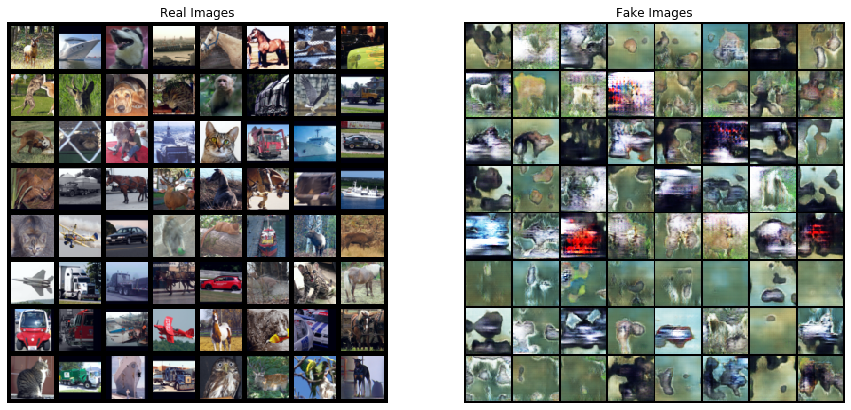

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('../figures/loss.svg')
plt.clf()

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig("../figures/real_vs_fake.svg")


# SphereGAN ResNet Training

In [4]:
manual_seed = 101
random.seed(manual_seed)

torch.manual_seed(manual_seed)
genResnet = GeneratorResNet().to(device)

torch.manual_seed(manual_seed)
disResnet = DiscriminatorResNet().to(device)

torch.manual_seed(manual_seed)
genResnet.apply(weights_init)

torch.manual_seed(manual_seed)
disResnet.apply(weights_init)


DiscriminatorResNet(
  (conv1): conv3x3(
    (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (rb1): ResidualBlockDownSample(
    (avg_pool1): AdaptiveAvgPool2d(output_size=(24, 24))
    (conv_shortcut): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2)
    (relu2): LeakyReLU(negative_slope=0.2)
    (ln1): LayerNorm(torch.Size([256, 48, 48]), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm(torch.Size([256, 24, 24]), eps=1e-05, elementwise_affine=True)
    (conv_1): conv3x3(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (conv_2): conv3x3(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (avg_pool2): AdaptiveAvgPool2d(output_size=(24, 24))
  )
  (rb2): ResidualBlockDownSample(
    (avg_pool1): AdaptiveAvgPool2d(output_size=(12, 12))
    (conv_shortcut): Conv2d(256, 256, kernel_size

In [5]:
optimizerGenResnet = optim.Adam(genResnet.parameters(), lr=lr, betas=(beta1, beta2))
optimizerDiscResnet = optim.Adam(disResnet.parameters(), lr=lr, betas=(beta1, beta2))

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 128, device=device)
dataloader_resnet = get_stl10_dataloader(dataroot, batch_size, workers, image_size)

img_list_resnet = []
G_losses_resnet = []
D_losses_resnet = []
iters_resnet = 0
moments_resnet = 3

Files already downloaded and verified


In [ ]:
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_resnet, 0):

        ############################
        # (1) Update Discriminator
        ###########################
        disResnet.zero_grad()
        label = torch.full((batch_size,1), real_label, device=device)
        
        # Forward pass real batch through D
        output = disResnet(data[0].to(device))
        
        # Calculate loss on all-real batch
        error_disc_real = total_moment_distance(output, label, moments_resnet, device)
        
        # Calculate gradients for D in backward pass
        error_disc_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, 128, device=device)
        
        # Generate fake image batch with G
        fake = genResnet(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = disResnet(fake.detach())
        
        # Calculate D's loss on the all-fake batch
        error_disc_fake = total_moment_distance(output, label, moments_resnet, device)
        
        
        # Calculate the gradients for this batch
        error_disc_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        error_disc = error_disc_real + error_disc_fake
        #error_disc.backward()
        
        # Update D
        optimizerDiscResnet.step()

        ############################
        # (2) Update Generator
        ###########################
        genResnet.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disResnet(fake)
        
        # Calculate G's loss based on this output
        error_gen = total_moment_distance(output, label, moments_resnet, device)
        
        # Calculate gradients for G
        error_gen.backward()
        
        # Update G
        optimizerGenResnet.step()
        ln1 = getattr(genResnet, "ln1")
        _isnan = torch.isnan(ln1.weight)
        if _isnan.any():
            print(ln1.weight[_isnan])
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader_resnet),
                     error_disc.item(), error_gen.item()))
            #print("DISC FAKE LOSS: ", error_disc_fake)
            #print("GEN LOSS: ", error_gen)

        # Save Losses for plotting later
        G_losses_resnet.append(error_gen.item())
        D_losses_resnet.append(error_disc.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters_resnet % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_resnet)-1)):
            with torch.no_grad():
                fake = genResnet(fixed_noise).detach().cpu()
            img_list_resnet.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            plt.clf()
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list_resnet[-1],(1,2,0)))
            plt.savefig("../figures/Resnet_fake_iter_{}.svg".format(iters_resnet))
            plt.clf()


        iters_resnet += 1

[0/5000][0/78]	Loss_D: 0.0003	Loss_G: 0.0049
[0/5000][50/78]	Loss_D: -0.0067	Loss_G: 0.0017
[1/5000][0/78]	Loss_D: 0.0000	Loss_G: 0.0089
[1/5000][50/78]	Loss_D: -0.0012	Loss_G: 0.0059
[2/5000][0/78]	Loss_D: -0.0127	Loss_G: 0.0231
[2/5000][50/78]	Loss_D: -0.0043	Loss_G: 0.0208
[3/5000][0/78]	Loss_D: 0.0003	Loss_G: 0.0011
[3/5000][50/78]	Loss_D: -0.0001	Loss_G: 0.0018
[4/5000][0/78]	Loss_D: -0.0018	Loss_G: 0.0183
[4/5000][50/78]	Loss_D: -0.0005	Loss_G: 0.0177
[5/5000][0/78]	Loss_D: -0.0020	Loss_G: 0.0193
[5/5000][50/78]	Loss_D: -0.0157	Loss_G: 0.0383
[6/5000][0/78]	Loss_D: -0.0075	Loss_G: 0.0190
[6/5000][50/78]	Loss_D: -0.0436	Loss_G: 0.0221
[7/5000][0/78]	Loss_D: -0.0260	Loss_G: 0.0467
[7/5000][50/78]	Loss_D: -0.0443	Loss_G: 0.0447
[8/5000][0/78]	Loss_D: -0.0502	Loss_G: 0.0478
[8/5000][50/78]	Loss_D: -0.0496	Loss_G: 0.0591
[9/5000][0/78]	Loss_D: -0.0593	Loss_G: 0.0382
[9/5000][50/78]	Loss_D: -0.0726	Loss_G: 0.0579
[10/5000][0/78]	Loss_D: -0.0835	Loss_G: 0.0487
[10/5000][50/78]	Loss_D: -